<a href="https://colab.research.google.com/github/nmningmei/preprocessing_pipelines/blob/master/FSL_vs_nipype_fsl_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from IPython.display import Image

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


     |████████████████████████████████| 993kB 2.8MB/s 


In [3]:
!pip install nipype

In [5]:
!pip install nilearn

In [0]:
pipeline_id = 'https://drive.google.com/open?id=1f7QdeXsYp-0vgAguYoB07jqvqxvdgYVG'.split('id=')[-1]
downloaded = drive.CreateFile({'id':pipeline_id})
downloaded.GetContentFile('fMRIPipeline.png')

In [0]:
anat_head_id = 'https://drive.google.com/open?id=1lKgfvYKbu3NTR_xYybPal9o0vDSHxNEF'.split('id=')[-1]
downloaded = drive.CreateFile({'id':anat_head_id})
downloaded.GetContentFile('T1.nii')

In [0]:
func_id = 'https://drive.google.com/open?id=1lKgfvYKbu3NTR_xYybPal9o0vDSHxNEF'.split('id=')[-1]
downloaded = drive.CreateFile({'id':func_id})
downloaded.GetContentFile('func1.nii')

In [0]:
freesurferLUT_id = 'https://drive.google.com/open?id=1mFR_4D3o8EEYL_QZZh7BY8Bk_I26gnE4'.split('id=')[-1]
downloaded = drive.CreateFile({'id':freesurferLUT_id})
downloaded.GetContentFile('FreesurferLTU.csv')

In [0]:
ICA_id = 'https://drive.google.com/open?id=1UHM7RqIiPZTOJm1BVnKtHksOw40eAkTK'.split('id=')[-1]
downloaded = drive.CreateFile({'id':ICA_id})
downloaded.GetContentFile('ICA.jpg')

In [0]:
struc2BOLD_id = 'https://drive.google.com/open?id=1R0tPfL-9amcwF54wghG604UyHbw2_7Db'.split('id=')[-1]
downloaded = drive.CreateFile({'id':struc2BOLD_id})
downloaded.GetContentFile('struc2bold.jpg')

In [0]:
highpass_id = 'https://drive.google.com/open?id=1SPHrnAUXPRh6t6i9ihp3TXMJhX4vQPVC'.split('id=')[-1]
downloaded = drive.CreateFile({'id':highpass_id})
downloaded.GetContentFile('highpass.jpg')

# 1. FSL pipeline

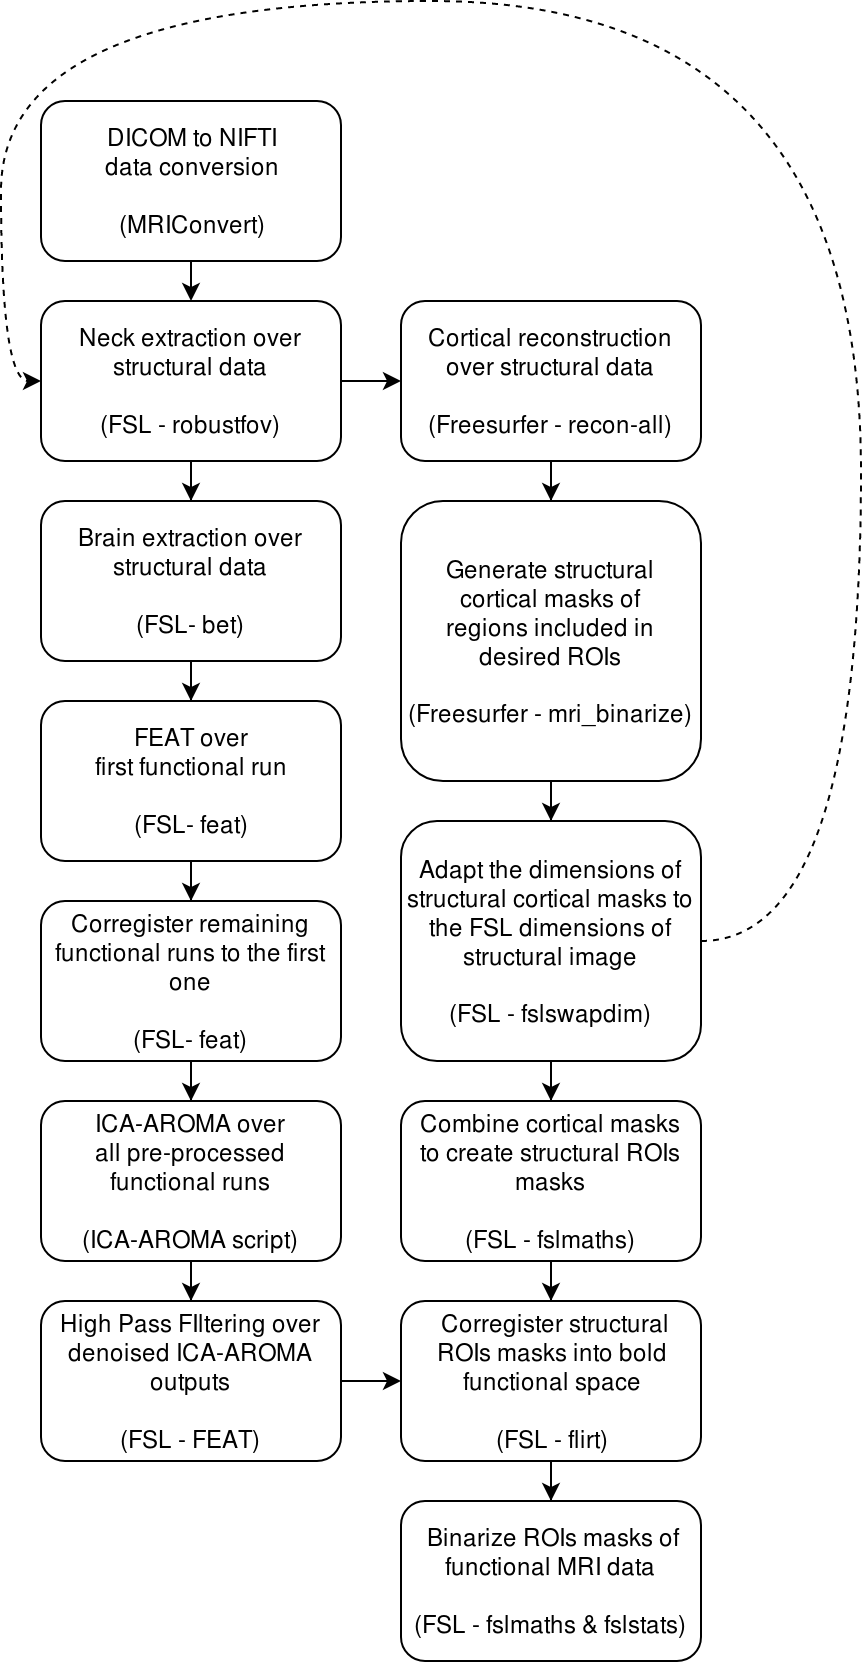

In [7]:
Image('fMRIPipeline.png',height=700)

# 2. access to cluster

```
ssh -X ips-0-1

password:

qlogin
```

# 3. setup environment

```
module load rocks-python-3.6

module load rocks-fsl-5.0.10

module load rocks-freesurfer-6.0.0

module load rocks-mricrogl

module load rocks-mricron-10.2014
```

# 4. convert from DICOM to NIfTI

Convert functional and structural files from DICOM format to NIfTI format (.nii) with MRIConvert software.
This process creates for each structural and functional file one referred as output.nii (and the output info.txt)
file, which is a 4D file with all the volumes. This files will be saved under each subjects nifty folder.

[dcm2nii:MainPage](https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage#Brain_Imaging_Data_Structure_.28BIDS.29_Support)
<br />[dcm2nii python wrapper](https://github.com/icometrix/dicom2nifti)

in the cluster, if th environment is setup right, we will have 2 commands available for the convertion: dcm2nii and dcm2niix.

Most medical imaging devices store images in variations of the complicated DICOM format. Many scientific tools expect medical images to be stored in the simpler NIfTI format. The [dcm2nii](http://www.mccauslandcenter.sc.edu/mricro/mricron/dcm2nii.html) is a popular tool for this. However, dcm2nii was initially developed before the NIfTI format as well as many modern variations of the DICOM format. In response I have created dcm2niix as a modern tool written in the C language. The advantages of the new tool is that it is simple (easier to adapt to vendor extensions to DICOM), easier to specify output file names, and written in a more popular language (C versus Pascal). It is also substantially faster, though image conversion is typically not a major factor in image analysis. The disadvantages of dcm2niix is that it is less heavily tested (and therefore may include bugs) and drops support for legacy image formats (if you are doing a archival study of images collected over a decade ago you should use dcm2nii as it supports ancient [proprietary formats](http://www.dclunie.com/medical-image-faq/html/toc.html) that predate DICOM). Both dcm2nii and dcm2niix can also convert proprietary Philips PAR/REC images to NIfTI. There are a lot of alternative tools from other developers. In particular, if you use Matlab I recommend [Xiangrui Li's dicm2nii](http://www.mathworks.com/matlabcentral/fileexchange/42997-dicom-to-nifti-converter). Another nice alternative is [Jolinda Smith's MRIconvert](http://lcni.uoregon.edu/~jolinda/MRIConvert/). In general, all these tools will produce similar results for MRI data from the major vendors (Siemens, GE, Philips). However, due to my team's exposure to large clinical datasets I think dcm2nii and dcm2niix may be more suitable for clinical environments (e.g. support for MRI or CT perfusion data where images are stored in color rather than grayscale and one needs to parse non-imaging related DICOM files like patient notes and sound files).

```
from nipype.interfaces.dcm2nii import Dcm2niix

converter = Dcm2niix()
converter.inputs.source_dir = os.path.abspath(where_the_data_locate)
converter.inputs.output_dir = os.path.abspath(where_you_want_put_the_data_into)
converter.inputs.single_file = True
converter.cmdline
temp = converter.run()
```

The python code above is equivalent to:
```
dcm2niix 
    -b y # BIDS sidecar, did not specified, default "yes"
    -z y # Output compression, did not specified, default "yes"
    -x n # Crop output, did not specified, default "no"
    -t n # not occur in the documentation
    -m n # Merge 2D slices, did not specified, default "no"
    -o where_you_want_put_the_data_into # output_dir
    -s y  # single_file
    -v n where_the_data_locate # source_dir
```

# 5. move files around and delete the unnecessary files

This part is semi-manual-automatic but **very important to match the behaviroal file to its corresponding fMRI run**

```
sub01 = {
        'Apr_03-1839':'ning_forest_2-run1-session2',
        'Apr_03-1850':'ning_forest_2-run2-session2',
        'Apr_03-1858':'ning_forest_2-run3-session2',
        'Apr_03-1907':'ning_forest_2-run4-session2',
        'Apr_03-1916':'ning_forest_2-run5-session2',
        'Apr_03-1927':'ning_forest_2-run6-session2',
        'Apr_03-1936':'ning_forest_2-run7-session2',
        'Apr_03-1947':'ning_forest_2-run8-session2',
        'Apr_03-1956':'ning_forest_2-run9-session2',
        'Apr_04-1835':'NING_FORREST_3-run1-session3',
        'Apr_04-1846':'NING_FORREST_3-run2-session3',
        'Apr_04-1855':'NING_FORREST_3-run3-session3',
        'Apr_04-1903':'NING_FORREST_3-run4-session3',
        'Apr_04-1912':'NING_FORREST_3-run5-session3',
        'Apr_04-1921':'NING_FORREST_3-run6-session3',
        'Apr_04-1930':'NING_FORREST_3-run7-session3',
        'Apr_04-1939':'NING_FORREST_3-run8-session3',
        'Apr_04-1947':'NING_FORREST_3-run9-session3',
        'Apr_05-1919':'NING_FORREST_4-run1-session4',
        'Apr_05-1938':'NING_FORREST_4-run3-session4',
        'Apr_05-1947':'NING_FORREST_4-run4-session4',
        'Apr_05-1955':'NING_FORREST_4-run5-session4',
        'Apr_05-2004':'NING_FORREST_4-run61-session4',
        'Apr_05-2015':'NING_FORREST_4-run62-session4',
        'Apr_05-2026':'NING_FORREST_4-run7-session4',
        'Apr_05-2034':'NING_FORREST_4-run8-session4',
        'Apr_05-2045':'NING_FORREST_4-run9-session4',
        'Apr_09-1446':'NING_FOREST_5-run1-session5',
        'Apr_09-1457':'NING_FOREST_5-run2-session5',
        'Apr_09-1506':'NING_FOREST_5-run3-session5',
        'Apr_09-1515':'NING_FOREST_5-run4-session5',
        'Apr_09-1523':'NING_FOREST_5-run5-session5',
        'Apr_09-1531':'NING_FOREST_5-run6-session5',
        'Apr_09-1540':'NING_FOREST_5-run7-session5',
        'Apr_09-1550':'NING_FOREST_5-run8-session5',
        'Apr_09-1559':'NING_FOREST_5-run9-session5',
        'Apr_09-1822':'NING_FORREST_6-run1-session6',
        'Apr_09-1835':'NING_FORREST_6-run2-session6',
        'Apr_09-1843':'NING_FORREST_6-run3-session6',
        'Apr_09-1853':'NING_FORREST_6-run4-session6',
        'Apr_09-1902':'NING_FORREST_6-run5-session6',
        'Apr_09-1917':'NING_FORREST_6-run6-session6',
        'Apr_09-1926':'NING_FORREST_6-run7-session6',
        'Apr_09-1936':'NING_FORREST_6-run8-session6',
        'Apr_09-1946':'NING_FORREST_6-run9-session6',
        'May_07-1541':'NING_FOREST_1-run1-session7',
        'May_07-1552':'NING_FOREST_1-run2-session7',
        'May_07-1601':'NING_FOREST_1-run3-session7',
        'May_07-1609':'NING_FOREST_1-run4-session7',
        'May_07-1622':'NING_FOREST_1-run5-session7',
        'May_07-1631':'NING_FOREST_1-run6-session7',
        'May_07-1639':'NING_FOREST_1-run7-session7',
        'May_07-1649':'NING_FOREST_1-run8-session7',
        'May_07-1658':'NING_FOREST_1-run9-session7',
        }
```

# 6. BET, brain extraction of structural Images

In [0]:
from nipype.interfaces import fsl
from nilearn.plotting import plot_anat
import numpy as np
import os

In [0]:
def bet(in_file, frac = 0.40, robust = True):
    fsl.FSLCommand.set_default_output_type('NIFTI_GZ')
    skullstrip = fsl.BET()
    in_file = in_file
    skullstrip.inputs.in_file = os.path.abspath(in_file)
    skullstrip.inputs.out_file = os.path.abspath(
                                in_file.replace('.nii.gz',
                                                f'_{frac}_brain.nii.gz')
                                )
    skullstrip.inputs.frac = frac
    skullstrip.inputs.robust = robust
    return skullstrip

In [0]:
anat_head = 'T1.nii'
fracs = np.arange(0.3,0.75,0.05)
for frac in fracs:
    skullstrip = bet(anat_head,frac = round(frac,2),)
    print(skullstrip.cmdline)
    


bet /content/T1.nii /content/T1_0.3_brain.nii.gz -f 0.30 -R
bet /content/T1.nii /content/T1_0.35_brain.nii.gz -f 0.35 -R
bet /content/T1.nii /content/T1_0.4_brain.nii.gz -f 0.40 -R
bet /content/T1.nii /content/T1_0.45_brain.nii.gz -f 0.45 -R
bet /content/T1.nii /content/T1_0.5_brain.nii.gz -f 0.50 -R
bet /content/T1.nii /content/T1_0.55_brain.nii.gz -f 0.55 -R
bet /content/T1.nii /content/T1_0.6_brain.nii.gz -f 0.60 -R
bet /content/T1.nii /content/T1_0.65_brain.nii.gz -f 0.65 -R
bet /content/T1.nii /content/T1_0.7_brain.nii.gz -f 0.70 -R


Use this part to plot, but we cannot excute to show you the example because we don't have FSL installed on google
```
anat_head = 'T1.nii.gz'
fracs = np.arange(0.35,0.71,0.01)
for frac in fracs:
    skullstrip = bet(working_data,frac = round(frac,2),)
    print(skullstrip.cmdline)
    skullstrip.run()
    fig,ax = plt.subplots(figsize=(12,12))
    plot_anat(skullstrip.inputs.out_file,
              title = f'frac = {frac:.2f}',
              threshold = 0,
              draw_cross = False,
#              display_mode = 'z',
#              cut_coords = np.arange(-40,41,5),
              cut_coords = (0,0,0),
              black_bg = True,
              figure = fig,
              axes = ax,)
    fig.savefig(os.path.join(figure_dir,
                             f"bet_{frac:.2f}.png"),
    dpi = 300,
    facecolor = 'k',
    edgecolor = 'k',)
    plt.close('all')
```

And then you can just compare the figures to figure out which frac value to choose. You can always use smaller step size to find the better frac

# 7. pre-stat functional scans


## 7.1. function to create functional preprocessing workflow

In [0]:
def get_brightness_threshold(thresh):
    return [0.75 * val for val in thresh]

def get_brightness_threshold_double(thresh):
    return [2 * 0.75 * val for val in thresh]

def cartesian_product(fwhms, in_files, usans, btthresh):
    from nipype.utils.filemanip import ensure_list
    # ensure all inputs are lists
    in_files                = ensure_list(in_files)
    fwhms                   = [fwhms] if isinstance(fwhms, (int, float)) else fwhms
    # create cartesian product lists (s_<name> = single element of list)
    cart_in_file            = [
            s_in_file for s_in_file in in_files for s_fwhm in fwhms
                                ]
    cart_fwhm               = [
            s_fwhm for s_in_file in in_files for s_fwhm in fwhms
                                ]
    cart_usans              = [
            s_usans for s_usans in usans for s_fwhm in fwhms
                                ]
    cart_btthresh           = [
            s_btthresh for s_btthresh in btthresh for s_fwhm in fwhms
                                ]
    return cart_in_file, cart_fwhm, cart_usans, cart_btthresh

def getusans(x):
    return [[tuple([val[0], 0.5 * val[1]])] for val in x]

def create_fsl_FEAT_workflow_func(whichrun          = 0,
                                  whichvol          = 'middle',
                                  workflow_name     = 'nipype_mimic_FEAT',
                                  first_run         = True,
                                  func_data_file    = 'temp',
                                  fwhm              = 3):
    from nipype.workflows.fmri.fsl             import preprocess
    from nipype.interfaces                     import fsl
    from nipype.interfaces                     import utility as util
    from nipype.pipeline                       import engine as pe
    """
    Setup some functions and hyperparameters
    """
    fsl.FSLCommand.set_default_output_type('NIFTI_GZ')
    pickrun             = preprocess.pickrun
    pickvol             = preprocess.pickvol
    getthreshop         = preprocess.getthreshop
    getmeanscale        = preprocess.getmeanscale
#    chooseindex         = preprocess.chooseindex
    
    """
    Start constructing the workflow graph
    """
    preproc             = pe.Workflow(name = workflow_name)
    """
    Initialize the input and output spaces
    """
    inputnode           = pe.Node(
                        interface   = util.IdentityInterface(fields = ['func',
                                                                       'fwhm',
                                                                       'anat']),
                        name        = 'inputspec')
    outputnode          = pe.Node(
                        interface   = util.IdentityInterface(fields = ['reference',
                                                                       'motion_parameters',
                                                                       'realigned_files',
                                                                       'motion_plots',
                                                                       'mask',
                                                                       'smoothed_files',
                                                                       'mean']),
                        name        = 'outputspec')
    """
    first step: convert Images to float values
    """
    img2float           = pe.MapNode(
                        interface   = fsl.ImageMaths(
                                        out_data_type   = 'float',
                                        op_string       = '',
                                        suffix          = '_dtype'),
                        iterfield   = ['in_file'],
                        name        = 'img2float')
    preproc.connect(inputnode,'func',
                    img2float,'in_file')
    """
    delete first 10 volumes
    """
    develVolume         = pe.MapNode(
                        interface   = fsl.ExtractROI(t_min  = 10,
                                                     t_size = 508),
                        iterfield   = ['in_file'],
                        name        = 'remove_volumes')
    preproc.connect(img2float,      'out_file',
                    develVolume,    'in_file')
    if first_run == True:
        """ 
        extract example fMRI volume: middle one
        """
        extract_ref     = pe.MapNode(
                        interface   = fsl.ExtractROI(t_size = 1,),
                        iterfield   = ['in_file'],
                        name        = 'extractref')
        # connect to the deleteVolume node to get the data
        preproc.connect(develVolume,'roi_file',
                        extract_ref,'in_file')
        # connect to the deleteVolume node again to perform the extraction
        preproc.connect(develVolume,('roi_file',pickvol,0,whichvol),
                        extract_ref,'t_min')
        # connect to the output node to save the reference volume
        preproc.connect(extract_ref,'roi_file',
                        outputnode, 'reference')
    if first_run == True:
        """
        Realign the functional runs to the reference (`whichvol` volume of first run)
        """
        motion_correct  = pe.MapNode(
                        interface   = fsl.MCFLIRT(save_mats     = True,
                                                  save_plots    = True,
                                                  save_rms      = True,
                                                  stats_imgs    = True,
                                                  interpolation = 'spline'),
                        iterfield   = ['in_file','ref_file'],
                        name        = 'MCFlirt',
                                                  )
        # connect to the develVolume node to get the input data
        preproc.connect(develVolume,    'roi_file',
                        motion_correct, 'in_file',)
        ######################################################################################
        #################  the part where we replace the actual reference image if exists ####
        ######################################################################################
        # connect to the develVolume node to get the reference
        preproc.connect(extract_ref,    'roi_file', 
                        motion_correct, 'ref_file')
        ######################################################################################
        # connect to the output node to save the motion correction parameters
        preproc.connect(motion_correct, 'par_file',
                        outputnode,     'motion_parameters')
        # connect to the output node to save the other files
        preproc.connect(motion_correct, 'out_file',
                        outputnode,     'realigned_files')
    else:
        """
        Realign the functional runs to the reference (`whichvol` volume of first run)
        """
        motion_correct      = pe.MapNode(
                            interface   = fsl.MCFLIRT(ref_file      = first_run,
                                                      save_mats     = True,
                                                      save_plots    = True,
                                                      save_rms      = True,
                                                      stats_imgs    = True,
                                                      interpolation = 'spline'),
                            iterfield   = ['in_file','ref_file'],
                            name        = 'MCFlirt',
                        )
        # connect to the develVolume node to get the input data
        preproc.connect(develVolume,    'roi_file',
                        motion_correct, 'in_file',)
        # connect to the output node to save the motion correction parameters
        preproc.connect(motion_correct, 'par_file',
                        outputnode,     'motion_parameters')
        # connect to the output node to save the other files
        preproc.connect(motion_correct, 'out_file',
                        outputnode,     'realigned_files')
    """
    plot the estimated motion parameters
    """
    plot_motion             = pe.MapNode(
                            interface   = fsl.PlotMotionParams(in_source = 'fsl'),
                            iterfield   = ['in_file'],
                            name        = 'plot_motion',
            )
    plot_motion.iterables = ('plot_type',['rotations',
                                          'translations',
                                          'displacement'])
    preproc.connect(motion_correct, 'par_file',
                    plot_motion,    'in_file')
    preproc.connect(plot_motion,    'out_file',
                    outputnode,     'motion_plots')
    """
    extract the mean volume of the first functional run
    """
    meanfunc                = pe.Node(
                            interface  = fsl.ImageMaths(op_string   = '-Tmean',
                                                        suffix      = '_mean',),
                            name        = 'meanfunc')
    preproc.connect(motion_correct, ('out_file',pickrun,whichrun),
                    meanfunc,       'in_file')
    """
    strip the skull from the mean functional to generate a mask
    """
    meanfuncmask            = pe.Node(
                            interface   = fsl.BET(mask        = True,
                                                  no_output   = True,
                                                  frac        = 0.3,
                                                  surfaces    = True,),
                            name        = 'bet2_mean_func')
    preproc.connect(meanfunc,       'out_file',
                    meanfuncmask,   'in_file')
    """
    Mask the motion corrected functional data with the mask to create the masked (bet) motion corrected functional data
    """
    maskfunc                = pe.MapNode(
                            interface   = fsl.ImageMaths(suffix = '_bet',
                                                         op_string = '-mas'),
                            iterfield   = ['in_file'],
                            name        = 'maskfunc')
    preproc.connect(motion_correct, 'out_file',
                    maskfunc,       'in_file')
    preproc.connect(meanfuncmask,   'mask_file',
                    maskfunc,       'in_file2')
    """
    determine the 2nd and 98th percentiles of each functional run
    """
    getthreshold            = pe.MapNode(
                            interface   = fsl.ImageStats(op_string = '-p 2 -p 98'),
                            iterfield   = ['in_file'],
                            name        = 'getthreshold')
    preproc.connect(maskfunc,       'out_file',
                    getthreshold,   'in_file')
    """
    threshold the functional data at 10% of the 98th percentile
    """
    threshold               = pe.MapNode(
                            interface   = fsl.ImageMaths(out_data_type  = 'char',
                                                         suffix         = '_thresh',
                                                         op_string      = '-Tmin -bin'),
                            iterfield   = ['in_file','op_string'],
                            name        = 'tresholding')
    preproc.connect(maskfunc, 'out_file',
                    threshold,'in_file')
    """
    define a function to get 10% of the intensity
    """
    preproc.connect(getthreshold,('out_stat',getthreshop),
                    threshold,    'op_string')
    """
    Determine the median value of the functional runs using the mask
    """
    medianval               = pe.MapNode(
                            interface   = fsl.ImageStats(op_string = '-k %s -p 50'),
                            iterfield   = ['in_file','mask_file'],
                            name        = 'cal_intensity_scale_factor')
    preproc.connect(motion_correct,     'out_file',
                    medianval,          'in_file')
    preproc.connect(threshold,          'out_file',
                    medianval,          'mask_file')
    """
    dilate the mask
    """
    dilatemask              = pe.MapNode(
                            interface   = fsl.ImageMaths(suffix = '_dil',
                                                         op_string = '-dilF'),
                            iterfield   = ['in_file'],
                            name        = 'dilatemask')
    preproc.connect(threshold,  'out_file',
                    dilatemask, 'in_file')
    preproc.connect(dilatemask, 'out_file',
                    outputnode, 'mask')
    """
    mask the motion corrected functional runs with the dilated mask
    """
    dilateMask_MCed         = pe.MapNode(
                            interface   = fsl.ImageMaths(suffix     = '_mask',
                                                         op_string  = '-mas'),
                            iterfield   = ['in_file','in_file2'],
                            name        = 'dilateMask_MCed')
    preproc.connect(motion_correct,     'out_file',
                    dilateMask_MCed,    'in_file',)
    preproc.connect(dilatemask,         'out_file',
                    dilateMask_MCed,    'in_file2')
    """
    We now take this functional data that is motion corrected, high pass filtered, and
    create a "mean_func" image that is the mean across time (Tmean)
    """
    meanfunc2               = pe.MapNode(
                            interface   = fsl.ImageMaths(suffix     = '_mean',
                                                         op_string  = '-Tmean',),
                            iterfield   = ['in_file'],
                            name        = 'meanfunc2')
    preproc.connect(dilateMask_MCed,    'out_file',
                    meanfunc2,          'in_file')
    """
    smooth each run using SUSAN with the brightness threshold set to 
    75% of the median value for each run and a mask constituing the 
    mean functional
    """
    merge                   = pe.Node(
                            interface   = util.Merge(2, axis = 'hstack'), 
                            name        = 'merge')
    preproc.connect(meanfunc2,  'out_file', 
                    merge,      'in1')
    preproc.connect(medianval,('out_stat',get_brightness_threshold_double), 
                    merge,      'in2')
    smooth                  = pe.MapNode(
                            interface   = fsl.SUSAN(dimension   = 3,
                                                    use_median  = True),
                            iterfield   = ['in_file',
                                           'brightness_threshold',
                                           'fwhm',
                                           'usans'],
                            name        = 'susan_smooth')
    preproc.connect(dilateMask_MCed,    'out_file', 
                    smooth,             'in_file')
    preproc.connect(medianval,         ('out_stat',get_brightness_threshold),
                    smooth,             'brightness_threshold')
    preproc.connect(inputnode,          'fwhm', 
                    smooth,             'fwhm')
    preproc.connect(merge,              ('out',getusans),
                    smooth,             'usans')
    """
    mask the smoothed data with the dilated mask
    """
    maskfunc3               = pe.MapNode(
                            interface   = fsl.ImageMaths(suffix     = '_mask',
                                                         op_string  = '-mas'),
                            iterfield   = ['in_file','in_file2'],
                            name        = 'dilateMask_smoothed')
    # connect the output of the susam smooth component to the maskfunc3 node
    preproc.connect(smooth,     'smoothed_file',
                    maskfunc3,  'in_file')
    # connect the output of the dilated mask to the maskfunc3 node
    preproc.connect(dilatemask, 'out_file',
                    maskfunc3,  'in_file2')
    """
    scale the median value of the run is set to 10000
    """
    meanscale               = pe.MapNode(
                            interface   = fsl.ImageMaths(suffix = '_intnorm'),
                            iterfield   = ['in_file','op_string'],
                            name        = 'meanscale')
    preproc.connect(maskfunc3, 'out_file',
                    meanscale, 'in_file')
    preproc.connect(meanscale, 'out_file',
                    outputnode,'smoothed_files')
    """
    define a function to get the scaling factor for intensity normalization
    """
    preproc.connect(medianval,('out_stat',getmeanscale),
                    meanscale,'op_string')
    """
    generate a mean functional image from the first run
    should this be the 'mean.nii.gz' we will use in the future?
    """
    meanfunc3               = pe.MapNode(
                            interface   = fsl.ImageMaths(suffix     = '_mean',
                                                         op_string  = '-Tmean',),
                            iterfield   = ['in_file'],
                            name        = 'gen_mean_func_img')
    preproc.connect(meanscale, 'out_file',
                    meanfunc3, 'in_file')
    preproc.connect(meanfunc3, 'out_file',
                    outputnode,'mean')
    
    
    # initialize some of the input files
    preproc.inputs.inputspec.func       = os.path.abspath(func_data_file)
    preproc.inputs.inputspec.fwhm       = 3
    preproc.base_dir                    = os.path.abspath('/'.join(
                                        func_data_file.split('/')[:-1]))
    
    output_dir                          = os.path.abspath(os.path.join(
                                        preproc.base_dir,
                                        'outputs',
                                        'func'))
    MC_dir                              = os.path.join(output_dir,'MC')
    for directories in [output_dir,MC_dir]:
        if not os.path.exists(directories):
            os.makedirs(directories)
    
    # initialize all the output files
    if first_run == True:
        preproc.inputs.extractref.roi_file      = os.path.abspath(os.path.join(
                output_dir,'example_func.nii.gz'))
    
    preproc.inputs.dilatemask.out_file          = os.path.abspath(os.path.join(
                output_dir,'mask.nii.gz'))
    preproc.inputs.meanscale.out_file           = os.path.abspath(os.path.join(
                output_dir,'prefiltered_func.nii.gz'))
    preproc.inputs.gen_mean_func_img.out_file   = os.path.abspath(os.path.join(
                output_dir,'mean_func.nii.gz'))
    
    return preproc,MC_dir,output_dir

In [0]:
preproc,MC_dir,output_dir = create_fsl_FEAT_workflow_func(
        workflow_name       = 'preprocess',
        first_run           = True,# or False
        func_data_file      = '.',
        fwhm                = 3,
        )
preproc.write_graph('preproc')

190715-19:27:21,451 nipype.workflow INFO:
	 Generated workflow graph: /content/preprocess/preproc.png (graph2use=hierarchical, simple_form=True).


'/content/preprocess/preproc.png'

## 7.2. FSL fsf file

```

    # FEAT version number
    set fmri(version) 6.00

    # Are we in MELODIC?
    set fmri(inmelodic) 0

    # Analysis level
    # 1 : First-level analysis
    # 2 : Higher-level analysis
    set fmri(level) 1

    # Which stages to run
    # 0 : No first-level analysis (registration and/or group stats only)
    # 7 : Full first-level analysis
    # 1 : Pre-processing
    # 2 : Statistics
    set fmri(analysis) 1

    # Use relative filenames
    set fmri(relative_yn) 0

    # Balloon help
    set fmri(help_yn) 1

    # Run Featwatcher
    set fmri(featwatcher_yn) 1

    # Cleanup first-level standard-space images
    set fmri(sscleanup_yn) 0

    # Output directory
    set fmri(outputdir) "/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01"

    # TR(s)
    set fmri(tr) 0.850000 

    # Total volumes
    set fmri(npts) 518

    # Delete volumes
    set fmri(ndelete) 10

    # Perfusion tag/control order
    set fmri(tagfirst) 1

    # Number of first-level analyses
    set fmri(multiple) 1

    # Higher-level input type
    # 1 : Inputs are lower-level FEAT directories
    # 2 : Inputs are cope images from FEAT directories
    set fmri(inputtype) 2

    # Carry out pre-stats processing?
    set fmri(filtering_yn) 1

    # Brain/background threshold, %
    set fmri(brain_thresh) 10

    # Critical z for design efficiency calculation
    set fmri(critical_z) 5.3

    # Noise level
    set fmri(noise) 0.66

    # Noise AR(1)
    set fmri(noisear) 0.34

    # Motion correction
    # 0 : None
    # 1 : MCFLIRT
    set fmri(mc) 1

    # Spin-history (currently obsolete)
    set fmri(sh_yn) 0

    # B0 fieldmap unwarping?
    set fmri(regunwarp_yn) 0

    # EPI dwell time (ms)
    set fmri(dwell) 0.7

    # EPI TE (ms)
    set fmri(te) 35

    # % Signal loss threshold
    set fmri(signallossthresh) 10

    # Unwarp direction
    set fmri(unwarp_dir) y-

    # Slice timing correction
    # 0 : None
    # 1 : Regular up (0, 1, 2, 3, ...)
    # 2 : Regular down
    # 3 : Use slice order file
    # 4 : Use slice timings file
    # 5 : Interleaved (0, 2, 4 ... 1, 3, 5 ... )
    set fmri(st) 0

    # Slice timings file
    set fmri(st_file) ""

    # BET brain extraction
    set fmri(bet_yn) 1

    # Spatial smoothing FWHM (mm)
    set fmri(smooth) 3.0

    # Intensity normalization
    set fmri(norm_yn) 0

    # Perfusion subtraction
    set fmri(perfsub_yn) 0

    # Highpass temporal filtering
    set fmri(temphp_yn) 0

    # Lowpass temporal filtering
    set fmri(templp_yn) 0

    # MELODIC ICA data exploration
    set fmri(melodic_yn) 0

    # Carry out main stats?
    set fmri(stats_yn) 0

    # Carry out prewhitening?
    set fmri(prewhiten_yn) 1

    # Add motion parameters to model
    # 0 : No
    # 1 : Yes
    set fmri(motionevs) 0
    set fmri(motionevsbeta) ""
    set fmri(scriptevsbeta) ""

    # Robust outlier detection in FLAME?
    set fmri(robust_yn) 0

    # Higher-level modelling
    # 3 : Fixed effects
    # 0 : Mixed Effects: Simple OLS
    # 2 : Mixed Effects: FLAME 1
    # 1 : Mixed Effects: FLAME 1+2
    set fmri(mixed_yn) 2

    # Number of EVs
    set fmri(evs_orig) 1
    set fmri(evs_real) 2
    set fmri(evs_vox) 0

    # Number of contrasts
    set fmri(ncon_orig) 1
    set fmri(ncon_real) 1

    # Number of F-tests
    set fmri(nftests_orig) 0
    set fmri(nftests_real) 0

    # Add constant column to design matrix? (obsolete)
    set fmri(constcol) 0

    # Carry out post-stats steps?
    set fmri(poststats_yn) 0

    # Pre-threshold masking?
    set fmri(threshmask) ""

    # Thresholding
    # 0 : None
    # 1 : Uncorrected
    # 2 : Voxel
    # 3 : Cluster
    set fmri(thresh) 3

    # P threshold
    set fmri(prob_thresh) 0.05

    # Z threshold
    set fmri(z_thresh) 2.3

    # Z min/max for colour rendering
    # 0 : Use actual Z min/max
    # 1 : Use preset Z min/max
    set fmri(zdisplay) 0

    # Z min in colour rendering
    set fmri(zmin) 2

    # Z max in colour rendering
    set fmri(zmax) 8

    # Colour rendering type
    # 0 : Solid blobs
    # 1 : Transparent blobs
    set fmri(rendertype) 1

    # Background image for higher-level stats overlays
    # 1 : Mean highres
    # 2 : First highres
    # 3 : Mean functional
    # 4 : First functional
    # 5 : Standard space template
    set fmri(bgimage) 1

    # Create time series plots
    set fmri(tsplot_yn) 1

    # Registration to initial structural
    set fmri(reginitial_highres_yn) 0

    # Search space for registration to initial structural
    # 0   : No search
    # 90  : Normal search
    # 180 : Full search
    set fmri(reginitial_highres_search) 90

    # Degrees of Freedom for registration to initial structural
    set fmri(reginitial_highres_dof) 3

    # Registration to main structural
    set fmri(reghighres_yn) 1

    # Search space for registration to main structural
    # 0   : No search
    # 90  : Normal search
    # 180 : Full search
    set fmri(reghighres_search) 180

    # Degrees of Freedom for registration to main structural
    set fmri(reghighres_dof) 7

    # Registration to standard image?
    set fmri(regstandard_yn) 1

    # Use alternate reference images?
    set fmri(alternateReference_yn) 0

    # Standard image
    set fmri(regstandard) "/opt/fsl/fsl-5.0.9/fsl/data/standard/MNI152_T1_2mm_brain"

    # Search space for registration to standard space
    # 0   : No search
    # 90  : Normal search
    # 180 : Full search
    set fmri(regstandard_search) 180

    # Degrees of Freedom for registration to standard space
    set fmri(regstandard_dof) 12

    # Do nonlinear registration from structural to standard space?
    set fmri(regstandard_nonlinear_yn) 1

    # Control nonlinear warp field resolution
    set fmri(regstandard_nonlinear_warpres) 10 

    # High pass filter cutoff
    set fmri(paradigm_hp) 99999

    # Total voxels
    set fmri(totalVoxels) 264751872


    # Number of lower-level copes feeding into higher-level analysis
    set fmri(ncopeinputs) 0

    # 4D AVW data or FEAT directory (1)
    set feat_files(1) "/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/sub-01_unfeat_run-01_bold"

    # Add confound EVs text file
    set fmri(confoundevs) 0

    # Subject's structural image for analysis 1
    set highres_files(1) "/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/anat/sub-01-T1W_mprage_sag_p2_1iso_MGH_day_6_nipy_brain"

    # EV 1 title
    set fmri(evtitle1) ""

    # Basic waveform shape (EV 1)
    # 0 : Square
    # 1 : Sinusoid
    # 2 : Custom (1 entry per volume)
    # 3 : Custom (3 column format)
    # 4 : Interaction
    # 10 : Empty (all zeros)
    set fmri(shape1) 0

    # Convolution (EV 1)
    # 0 : None
    # 1 : Gaussian
    # 2 : Gamma
    # 3 : Double-Gamma HRF
    # 4 : Gamma basis functions
    # 5 : Sine basis functions
    # 6 : FIR basis functions
    set fmri(convolve1) 2

    # Convolve phase (EV 1)
    set fmri(convolve_phase1) 0

    # Apply temporal filtering (EV 1)
    set fmri(tempfilt_yn1) 1

    # Add temporal derivative (EV 1)
    set fmri(deriv_yn1) 1

    # Skip (EV 1)
    set fmri(skip1) 0

    # Off (EV 1)
    set fmri(off1) 30

    # On (EV 1)
    set fmri(on1) 30

    # Phase (EV 1)
    set fmri(phase1) 0

    # Stop (EV 1)
    set fmri(stop1) -1

    # Gamma sigma (EV 1)
    set fmri(gammasigma1) 3

    # Gamma delay (EV 1)
    set fmri(gammadelay1) 6

    # Orthogonalise EV 1 wrt EV 0
    set fmri(ortho1.0) 0

    # Orthogonalise EV 1 wrt EV 1
    set fmri(ortho1.1) 0

    # Contrast & F-tests mode
    # real : control real EVs
    # orig : control original EVs
    set fmri(con_mode_old) orig
    set fmri(con_mode) orig

    # Display images for contrast_real 1
    set fmri(conpic_real.1) 1

    # Title for contrast_real 1
    set fmri(conname_real.1) ""

    # Real contrast_real vector 1 element 1
    set fmri(con_real1.1) 1

    # Real contrast_real vector 1 element 2
    set fmri(con_real1.2) 0

    # Display images for contrast_orig 1
    set fmri(conpic_orig.1) 1

    # Title for contrast_orig 1
    set fmri(conname_orig.1) ""

    # Real contrast_orig vector 1 element 1
    set fmri(con_orig1.1) 1

    # Contrast masking - use >0 instead of thresholding?
    set fmri(conmask_zerothresh_yn) 0

    # Do contrast masking at all?
    set fmri(conmask1_1) 0

    ##########################################################
    # Now options that don't appear in the GUI

    # Alternative (to BETting) mask image
    set fmri(alternative_mask) ""

    # Initial structural space registration initialisation transform
    set fmri(init_initial_highres) ""

    # Structural space registration initialisation transform
    set fmri(init_highres) ""

    # Standard space registration initialisation transform
    set fmri(init_standard) ""

    # For full FEAT analysis: overwrite existing .feat output dir?
    set fmri(overwrite_yn) 0
```

## 7.3. log report of the FSL GUI pipeline

<HTML><HEAD>
<!--refreshstart-->

<!--refreshstop-->
<link REL=stylesheet TYPE=text/css href=.files/fsl.css>
<TITLE>FSL</TITLE></HEAD><BODY><OBJECT data=report.html></OBJECT>
<h2>Progress Report / Log</h2>
Started at Tue Apr 30 13:04:17 CEST 2019<p>
Feat main script<br><pre>

/bin/cp /bcbl/home/public/Consciousness/uncon_feat/scripts/MRI/standard/session02.run01/run01.fsf design.fsf

mkdir .files;cp /opt/fsl/fsl-5.0.10/fsl/doc/fsl.css .files;cp -r /opt/fsl/fsl-5.0.10/fsl/doc/images .files/images

/opt/fsl/fsl-5.0.10/fsl/bin/fsl_sub -T 10 -l logs -N feat0_init   /opt/fsl/fsl-5.0.10/fsl/bin/feat /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/design.fsf -D /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat -I 1 -init
1323378

/opt/fsl/fsl-5.0.10/fsl/bin/fsl_sub -T 324 -l logs -N feat2_pre -j 1323378  /opt/fsl/fsl-5.0.10/fsl/bin/feat /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/design.fsf -D /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat -I 1 -prestats
1323379

/opt/fsl/fsl-5.0.10/fsl/bin/fsl_sub -T 75 -l logs -N feat3_film -j 1323379  /opt/fsl/fsl-5.0.10/fsl/bin/feat /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/design.fsf -D /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat -I 1 -stats
1323380

/opt/fsl/fsl-5.0.10/fsl/bin/fsl_sub -T 119 -l logs -N feat4_post -j 1323380  /opt/fsl/fsl-5.0.10/fsl/bin/feat /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/design.fsf -D /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat -poststats 0 
1323381

/opt/fsl/fsl-5.0.10/fsl/bin/fsl_sub -T 1 -l logs -N feat5_stop -j 1323379,1323380,1323381  /opt/fsl/fsl-5.0.10/fsl/bin/feat /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/design.fsf -D /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat -stop
1323382
</pre><hr>Initialisation<br><pre>

### convert image to float
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/sub-01_unfeat_run-01_bold prefiltered_func_data -odt float
Total original volumes = 518
Deleting 10 volume(s) - BE WARNED for future analysis!

### remove the first 10 volumes
/opt/fsl/fsl-5.0.10/fsl/bin/fslroi prefiltered_func_data prefiltered_func_data 10 508

### extract example volume from the middle
/opt/fsl/fsl-5.0.10/fsl/bin/fslroi prefiltered_func_data example_func 254 1
</pre><hr>Preprocessing:Stage 1<br><pre>

### setup some hyperparameters and create folder
/opt/fsl/fsl-5.0.10/fsl/bin/mainfeatreg -F 6.00 -d /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat -l /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/logs/feat2_pre -R /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/report_unwarp.html -r /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/report_reg.html  -i /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/example_func.nii.gz  -n 10 -h /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/anat/sub-01-T1W_mprage_sag_p2_1iso_MGH_day_6_nipy_brain -w  7 -x 180 -s /opt/fsl/fsl-5.0.9/fsl/data/standard/MNI152_T1_2mm_brain -y 12 -z 180 
Option -F ( FEAT version parameter ) selected with  argument "6.00"
Option -d ( output directory ) selected with  argument "/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat"
Option -l ( logfile )input with argument "/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/logs/feat2_pre"
Option -R ( html unwarping report ) selected with  argument "/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/report_unwarp.html"
Option -r ( html registration report ) selected with  argument "/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/report_reg.html"
Option -i ( main input ) input with argument "/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/FEAT.session02.run01.feat/example_func.nii.gz"
Option -n ( use nonlinear reg ) input with argument "10"
Option -h ( high-res structural image ) selected with  argument "/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/anat/sub-01-T1W_mprage_sag_p2_1iso_MGH_day_6_nipy_brain"
Option -w ( highres dof ) selected with  argument "7"
Option -x ( highres search ) selected with  argument "180"
Option -s ( standard image ) selected with  argument "/opt/fsl/fsl-5.0.9/fsl/data/standard/MNI152_T1_2mm_brain"
Option -y ( standard dof ) selected with  argument "12"
Option -z ( standard search ) selected with  argument "180"


</pre><hr>Preprocessing:Stage 2<br><pre>

### MCFLIRT, motion correction
/opt/fsl/fsl-5.0.10/fsl/bin/mcflirt -in prefiltered_func_data -out prefiltered_func_data_mcf -mats -plots -reffile example_func -rmsrel -rmsabs -spline_final
### create MCFLIRT folder
/bin/mkdir -p mc ; /bin/mv -f prefiltered_func_data_mcf.mat prefiltered_func_data_mcf.par prefiltered_func_data_mcf_abs.rms prefiltered_func_data_mcf_abs_mean.rms prefiltered_func_data_mcf_rel.rms prefiltered_func_data_mcf_rel_mean.rms mc

### plot motion correction results
/opt/fsl/fsl-5.0.10/fsl/bin/fsl_tsplot -i prefiltered_func_data_mcf.par -t 'MCFLIRT estimated rotations (radians)' -u 1 --start=1 --finish=3 -a x,y,z -w 640 -h 144 -o rot.png 

/opt/fsl/fsl-5.0.10/fsl/bin/fsl_tsplot -i prefiltered_func_data_mcf.par -t 'MCFLIRT estimated translations (mm)' -u 1 --start=4 --finish=6 -a x,y,z -w 640 -h 144 -o trans.png 

/opt/fsl/fsl-5.0.10/fsl/bin/fsl_tsplot -i prefiltered_func_data_mcf_abs.rms,prefiltered_func_data_mcf_rel.rms -t 'MCFLIRT estimated mean displacement (mm)' -u 1 -w 640 -h 144 -a absolute,relative -o disp.png 

### calculate the mean functional image across time
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_mcf -Tmean mean_func

### bet2 skull stripping on the mean functional image and rename the mask
/opt/fsl/fsl-5.0.10/fsl/bin/bet2 mean_func mask -f 0.3 -n -m; /opt/fsl/fsl-5.0.10/fsl/bin/immv mask_mask mask

### mask the motion corrected images
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_mcf -mas mask prefiltered_func_data_bet

### calculate the 2 and 98 percentile threshold on the bet2 images
/opt/fsl/fsl-5.0.10/fsl/bin/fslstats prefiltered_func_data_bet -p 2 -p 98
0.000000 13825.000000 

### apply the 10% of the 98 percentile threshold to create a binary mask - threshold mask
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_bet -thr 1382.5 -Tmin -bin mask -odt char

### calculate the scaling intensity for later use
/opt/fsl/fsl-5.0.10/fsl/bin/fslstats prefiltered_func_data_mcf -k mask -p 50
8256.169922 

### dilatemask
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths mask -dilF mask

### apply the dilate mask to the motion corrected images
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_mcf -mas mask prefiltered_func_data_thresh

### compute the mean functional image across time according to the dilatemasked images
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_thresh -Tmean mean_func

### susan smoothing - 6192.1274415 is 75% of the median intensity differences. 
/opt/fsl/fsl-5.0.10/fsl/bin/susan prefiltered_func_data_thresh 6192.1274415 1.27388535032 3 1 1 mean_func 6192.1274415 prefiltered_func_data_smooth

### apply the dilate mask to the smoothed data
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_smooth -mas mask prefiltered_func_data_smooth

### mean scale the masked smoothed data using the scaling intensity value: 10000 / [that_value]
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_smooth -mul 1.21121538128 prefiltered_func_data_intnorm

### rename the data
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_intnorm filtered_func_data

### calculate the mean functional image of the smoothed and masked images, and it is the "mean.nii.gz" in the folder
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths filtered_func_data -Tmean mean_func

/bin/rm -rf prefiltered_func_data*

</pre><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br></BODY></HTML>

## 7.4. call the function to create the workflow
## 7.4. setup the functional diretory, the output directory, and the mcflirt output directory

In [0]:
import os
functional_data = 'func1.nii'
output_dir = 'outputs'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
MC_dir = 'MC'
if not os.path.exists(os.path.join(output_dir,MC_dir)):
    os.mkdir(os.path.join(output_dir,MC_dir))

## 7.5. call the the workflow function and setup the input values like functional data directory and the spatial smoothing size, as well as the output directory.
## since this is a demonstration of preprocessing the first run, we will extract a volume as the reference volume (example_func.nii.gz)

In [0]:
workflow_name = 'nipype_mimic_FEAT'
first_run = True
preproc,_,_ = create_fsl_FEAT_workflow_func(workflow_name = workflow_name,)
# if have run the first run, you will get a example_func.nii.gz as the functional reference, and you can pass this to the function to create a 
# slightly different work flow
# initialize some of the input files
preproc.inputs.inputspec.func = functional_data
preproc.inputs.inputspec.fwhm = 3
preproc.base_dir = output_dir

# initialize all the output files
if first_run == True:
    preproc.inputs.extractref.roi_file = os.path.abspath(os.path.join(output_dir,
                                                                       'example_func.nii.gz'))
else:
    copyfile(first_run,output_dir,'example_func.nii.gz')

preproc.inputs.dilatemask.out_file = os.path.abspath(os.path.join(output_dir,
                                                              'mask.nii.gz'))
preproc.inputs.meanscale.out_file = os.path.abspath(os.path.join(output_dir,
                                                                        'prefiltered_func.nii.gz'))
preproc.inputs.gen_mean_func_img.out_file = os.path.abspath(os.path.join(output_dir,
                                                              'mean_func.nii.gz'))
preproc.write_graph()

190715-19:32:00,267 nipype.workflow INFO:
	 Generated workflow graph: outputs/nipype_mimic_FEAT/graph.png (graph2use=hierarchical, simple_form=True).


'outputs/nipype_mimic_FEAT/graph.png'

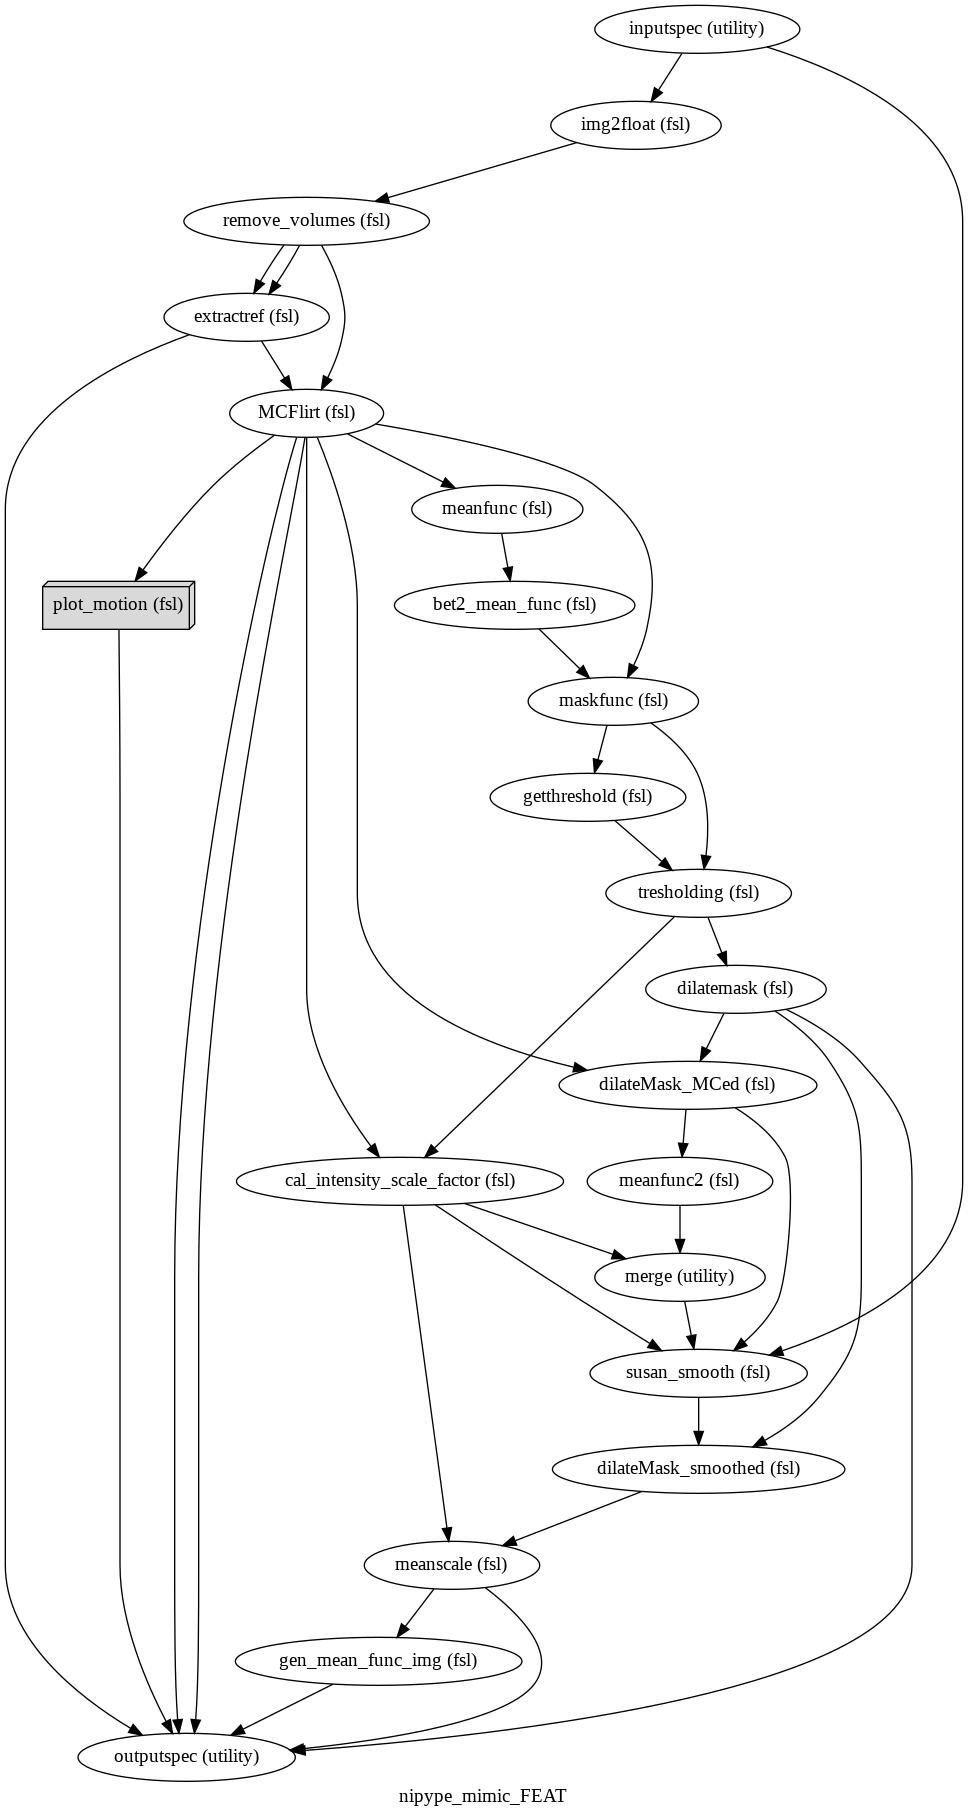

In [0]:
Image(f'{output_dir}/{workflow_name}/graph.png',height = 900)

## 7.5. How do we map the nipype workflow node to the lines excuted by the FSL pipeline?

### Many thanks to this github repo: https://github.com/vsoch/ica-/blob/master/melodic_ss.sh, but the SUSAN smoothing is wrongly interpreted. 

#### nipype workflow node:
1. Mapnode()
2. interface: a fsl wrapper function
3. iterfield: input placeholders
4. name: name of node

### 7.5.1. Inputspec: takes 2 parameters: "func" for the next processing, "fwhm" for spatial smoothing (in mm)
```
inputnode = pe.Node(
            interface = util.IdentityInterface(
                    fields=['func','fwhm','anat']),
                    name = 'inputspec')
```                        
#### "anat" is for later implementation


### 7.5.2. img2float: convert nii to float values
```
img2float = pe.MapNode(
            interface=fsl.ImageMaths(
                    out_data_type='float',op_string='',suffix='_dtype'),
                    iterfield=['in_file'],
                    name = 'img2float')
    preproc.connect(inputnode,'func',img2float,'in_file')
```
#### *nipype-generated*
```
fslmath <input_image.nii> <output_image.float> -odt float
```
#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/sub-01_unfeat_run-01_bold prefiltered_func_data -odt float

# fslmaths <image.nii> -odt float
```

### 7.5.3. remove_volumes
```
develVolume = pe.MapNode(
        interface = fsl.ExtractROI(t_min = 10,t_size = 508),
        iterfield = ['in_file'],
        name = 'remove_volumes')
preproc.connect(img2float,'out_file',develVolume,'in_file')
```

#### *nipype-generated*
```fslroi 
/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/img2float/mapflow/_img2float0/sub-01_unfeat_run-01_bold_dtype.nii.gz 
/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/remove_volumes/mapflow/_remove_volumes0/sub-01_unfeat_run-01_bold_dtype_roi.nii.gz 10 508

# fslroi <image.nii> <output_image.nii> <number_to_remove> <number_remain>
```
#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fslroi prefiltered_func_data prefiltered_func_data 10 508

# fslroi <image.nii> <output_image.nii> <number_to_remove> <number_remain>
```

### 7.5.4. optional: difference between the first run and the rest is to extract the reference for motion correct (realignment)
```
if first_run == True:
        """
        Realign the functional runs to the reference (`whichvol` volume of first run)
        """
        motion_correct = pe.MapNode(
                interface = fsl.MCFLIRT(
                        save_mats = True, # save transform matrices
                        save_plots = True, # save transform parameters for plotting
                        save_rms = True, # save rms displacement parameters
                        stats_imgs = True, # produce variance and std. dev. images
                        interpolation = 'spline' # interpolation method for transformation
                        ),
                        iterfield = ['in_file','ref_file'],
                        name = 'MCFlirt',
                        )
        # connect to the develVolume node to get the input data
        preproc.connect(develVolume,'roi_file',
                        motion_correct,'in_file',)
        ######################################################################################
        #################  the part where we replace the actual reference image if exists ####
        ######################################################################################
        # connect to the develVolume node to get the reference
        preproc.connect(extract_ref, 'roi_file', 
                        motion_correct,'ref_file')
        ######################################################################################
        # connect to the output node to save the motion correction parameters
        preproc.connect(motion_correct,'par_file',
                        outputnode,'motion_parameters')
        # connect to the output node to save the other files
        preproc.connect(motion_correct,'out_file',
                        outputnode,'realigned_files')
```
#### *nipype-generated*
```
fslroi 
/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/remove_volumes/mapflow/_remove_volumes0/sub-01_unfeat_run-01_bold_dtype_roi.nii.gz 
/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/outputs/func/example_func.nii.gz 254 1
# fslroi <image.nii> <index_of_reference_volume> <number_of_output_image>


mcflirt 
-in /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/remove_volumes/mapflow/_remove_volumes0/sub-01_unfeat_run-01_bold_dtype_roi.nii.gz 
-spline_final 
-out /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/MCFlirt/mapflow/_MCFlirt0/sub-01_unfeat_run-01_bold_dtype_roi_mcf.nii.gz 
-reffile /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/outputs/func/example_func.nii.gz 
-mats -plots -rmsabs -rmsrel -stats
# mcflirt -in <input_image.nii> <interpolation_method> -out <output_image.nii> -reffile <reference_volume.nii> 
-mats -plots -rmsabs -rmsrel # see below
-stats # produce variance and std. dev. images
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fslroi prefiltered_func_data example_func 254 1
# fslroi <image.nii> <index_of_reference_volume> <number_of_output_image>

/opt/fsl/fsl-5.0.10/fsl/bin/mcflirt -in prefiltered_func_data -out prefiltered_func_data_mcf -mats -plots -reffile example_func -rmsrel -rmsabs -spline_final

# mcflirt -in <all_volumes.nii> -out <output_volumes.nii> 
 -mats # save transformation matrices
 -plots # save transformation parameters
 -reffile <reference_volume.nii>
 -rmsrel -rmsabs # save rms displacement parameters
 -spline_final # interpolation method for transformation
```

#### 7.5.4.1. if there exist a reference "example_func.nii.gz", we can directly input it to the mcflirt algorithm

    else:
            """
            Realign the functional runs to the reference ref_file
            """
            motion_correct = pe.MapNode(
                    interface = fsl.MCFLIRT(
                            ref_file = first_run, # the only difference from above
                            save_mats = True,
                            save_plots = True,
                            save_rms = True,
                            stats_imgs = True,
                            interpolation = 'spline'),
                            iterfield = ['in_file','ref_file'],
                            name = 'MCFlirt',
                            )
            # connect to the develVolume node to get the input data
            preproc.connect(develVolume,'roi_file',
                            motion_correct,'in_file',)
            # connect to the output node to save the motion correction parameters
            preproc.connect(motion_correct,'par_file',
                            outputnode,'motion_parameters')
            # connect to the output node to save the other files
            preproc.connect(motion_correct,'out_file',
                            outputnode,'realigned_files')



### 7.5.5. plot_motion: plot the estimated motion parameters
```
plot_motion = pe.MapNode(
            interface=fsl.PlotMotionParams(in_source='fsl'
            ),
            iterfield = ['in_file'],
            name = 'plot_motion',
            )
    plot_motion.iterables = ('plot_type',['rotations',    # plot rotations (radians)
 'translations', # plot translations (mm)
 'displacement'  # plot mean displacement (mm)
 ])
    preproc.connect(motion_correct,'par_file',
                    plot_motion,'in_file')
    preproc.connect(plot_motion,'out_file',
                    outputnode,'motion_plots')
```
#### *nipype-generated*
```
fsl_tsplot -i /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/MCFlirt/mapflow/_MCFlirt0/sub-01_unfeat_run-01_bold_dtype_roi_mcf.nii.gz.par -o /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/MCFlirt/mapflow/_MCFlirt0/sub-01_unfeat_run-01_bold_dtype_roi_mcf.nii.gz_disp.png -t 'MCFLIRT estimated mean displacement (mm)' -a abs,rel

fsl_tsplot -i /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/MCFlirt/mapflow/_MCFlirt0/sub-01_unfeat_run-01_bold_dtype_roi_mcf.nii.gz.par -o /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/MCFlirt/mapflow/_MCFlirt0/sub-01_unfeat_run-01_bold_dtype_roi_mcf.nii.gz_rot.png -t 'MCFLIRT estimated rotations (radians)' --start=1 --finish=3 -a x,y,z

fsl_tsplot -i /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/MCFlirt/mapflow/_MCFlirt0/sub-01_unfeat_run-01_bold_dtype_roi_mcf.nii.gz.par -o /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/MCFlirt/mapflow/_MCFlirt0/sub-01_unfeat_run-01_bold_dtype_roi_mcf.nii.gz_trans.png -t 'MCFLIRT estimated translations (mm)' --start=4 --finish=6 -a x,y,z
```
#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fsl_tsplot -i prefiltered_func_data_mcf.par -t 'MCFLIRT estimated rotations (radians)' -u 1 --start=1 --finish=3 -a x,y,z -w 640 -h 144 -o rot.png 

/opt/fsl/fsl-5.0.10/fsl/bin/fsl_tsplot -i prefiltered_func_data_mcf.par -t 'MCFLIRT estimated translations (mm)' -u 1 --start=4 --finish=6 -a x,y,z -w 640 -h 144 -o trans.png 

/opt/fsl/fsl-5.0.10/fsl/bin/fsl_tsplot -i prefiltered_func_data_mcf_abs.rms,prefiltered_func_data_mcf_rel.rms -t 'MCFLIRT estimated mean displacement (mm)' -u 1 -w 640 -h 144 -a absolute,relative -o disp.png 

# fsl_tsplot -i <mc_parameter_file> -t <what_to_plot> -u <I_don't_know> 
```

### 7.5.6. meanfunc: extract the mean volume of the functional run

    meanfunc = pe.Node(
                interface=fsl.ImageMaths(op_string = '-Tmean', # string defining the operation
                                         suffix='_mean', # out_file suffix
                                         ),
                name = 'meanfunc')
        preproc.connect(motion_correct,('out_file',pickrun,whichrun),
                        meanfunc,'in_file')

*[nipype-generated]*
#### fslmaths 
#### /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/MCFlirt/mapflow/_MCFlirt0/sub-01_unfeat_run-01_bold_dtype_roi_mcf.nii.gz 
#### -Tmean 
#### /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/meanfunc/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mean.nii.gz
##### fslmaths <image.nii> -Tmean <outpu_image.nii>

*[FSL GUI]*
### /opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_mcf -Tmean mean_func
#### fslmaths <image.nii> -Tmean <outpu_image.nii>

### 7.5.7. bet2_mean_func: strip the skull from the mean functional to generate a mask --- here is why the smoothing is different from the FSL GUI pipeline. The mask is estimated essentially different commands (bet vs bet2)
```
meanfuncmask = pe.Node(
        interface=fsl.BET(mask=True, # create binary mask image
                          no_output=True, # Don't generate segmented output
                          frac=0.3,
                          surfaces=True
                          ),
        name='bet2_mean_func')
preproc.connect(meanfunc,'out_file',
                meanfuncmask,'in_file')
```
#### bet 
#### /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/meanfunc/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mean.nii.gz 
#### /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/bet2_mean_func/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mean_brain.nii.gz 
#### -f 0.30 
#### -m 
#### -n
#### -A

##### bet 
##### <mean_image.nii> 
##### -f <fraction_for_bet>
##### -n # Don't generate segmented output
##### -m # create binary mask image
##### -A # run bet2 and then betsurf to get additional skull and scalp surfaces


### /opt/fsl/fsl-5.0.10/fsl/bin/bet2 mean_func mask -f 0.3 -n -m
#### bet2 <mean_image.nii> 
#### -f <fraction_for_bet>
#### -n # Don't generate segmented output
#### -m # create binary mask image

`bet2 has virtually the same functionality as the original bet command-line program. You can use the same command-line syntax as before, with the main addition being the -e option for outputting a "mesh" version of the estimated brain mask. `

`bet is a script which calls the bet2 binary - hence by default it will give the same results.  bet has more script-level options that wrap around bet2.`

### 7.5.8. maskfunc: Mask the motion corrected functional data with the mask to create the masked (bet) motion corrected functional data
```
maskfunc = pe.MapNode(
        interface=fsl.ImageMaths(suffix='_bet', # out_file suffix
        op_string='-mas' # string defining the operation
        ),
        iterfield=['in_file'],
        name='maskfunc')
preproc.connect(motion_correct,'out_file',
                maskfunc,'in_file')
preproc.connect(meanfuncmask,'mask_file',
                maskfunc,'in_file2')
```
#### *nipype-generated*
```
fslmaths 
/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/MCFlirt/mapflow/_MCFlirt0/sub-01_unfeat_run-01_bold_dtype_roi_mcf.nii.gz 
-mas /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/bet2_mean_func/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mean_brain_mask.nii.gz 
/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/maskfunc/mapflow/_maskfunc0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_bet.nii.gz

# fslmaths <mc_correct_image.nii> -mas <mask.nii> <output_image.nii>
```
#### *FSL GUI*
```
 /opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_mcf -mas mask prefiltered_func_data_bet
# fslmaths <mc_correct_image.nii> -mas <mask.nii> <output_image.nii>
```

### 7.5.9. getthreshold: determine the 2nd and 98th percentile of each functional run
```
getthreshold = pe.MapNode(
            interface=fsl.ImageStats(op_string='-p 2 -p 98'), # string defining the operation
            iterfield = ['in_file'],
            name='getthreshold')
preproc.connect(maskfunc,'out_file',getthreshold,'in_file')
```
#### *nipype-generated*
```
fslstats 
/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/maskfunc/mapflow/_maskfunc0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_bet.nii.gz 
-p 2 
-p 98

# fslstats <image.nii> -p <lower_percentile> -p <upper_percentile>
```

#### *FSL GUI*
```
 /opt/fsl/fsl-5.0.10/fsl/bin/fslstats prefiltered_func_data_bet -p 2 -p 98
 
# fslstats <image.nii> -p <lower_percentile> -p <upper_percentile>
```

### 7.5.10. Thresholding

#### 7.5.10.2 thresholding: threshold the functional data at 10% of the 98th percentile
```
threshold = pe.MapNode(
        interface=fsl.ImageMaths(out_data_type='char', # output datatype, one of (char, short, int, float, double, input)
        suffix='_thresh', # out_file suffix
                                 op_string = '-Tmin -bin'), # string defining the operation
        iterfield=['in_file','op_string'],
        name='tresholding')
preproc.connect(maskfunc,'out_file',threshold,'in_file')
```
#### *nipype-generated*
```
fslmaths 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/maskfunc/mapflow/_maskfunc0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_bet.nii.gz 
 -thr 1382.5000000000 
 -Tmin 
 -bin 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/tresholding/mapflow/_tresholding0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_bet_thresh.nii.gz 
 -odt char

fslmaths <image.nii> -thr <10 * upper percentile> 
 -Tmin # we want the minimum across time
 -bin # binary mask
 <mask.nii> 
 -odt char
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_bet -thr 1382.5 -Tmin -bin mask -odt char
# fslmaths <image.nii> -thr <10_%_upper_percentile> 
 -Tmin  # Tmin to specify we want the minimum across time
 -bin # use "mask" as a binary mask
 <mask.nii>
 -odt <output_datatype>




#### 7.5.10.2 define a function to get the 10%  of the intensity
```
preprocec.connect(getthreshold,('out_stat',getthreshop),threshold,'op_string')
```

### 7.5.11. dilatemask: difF is a spatial filtering option that specifies maximum filtering of all voxels
```
dilatemask = pe.MapNode(
        interface = fsl.ImageMaths(suffix='_dil',# out_file suffix
        op_string='-dilF'), # string defining the operation
        iterfield=['in_file'],
        name = 'dilatemask')
preproc.connect(threshold,'out_file',dilatemask,'in_file')
preproc.connect(dilatemask,'out_file',outputnode,'mask')
```

#### *nipype-generated*
```
fslmaths 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/tresholding/mapflow/_tresholding0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_bet_thresh.nii.gz 
 -dilF 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/outputs/func/mask.nii.gz
# fslmaths <mask.nii> -dilF <mask.nii>
```

#### FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths mask -dilF mask

# fslmaths <mask.nii> -dilF <mask.nii>
```

### 7.5.12. dilateMask_MCed: mask the motion corrected functional runs with the dilated mask
```
dilateMask_MCed = pe.MapNode(
        interface = fsl.ImageMaths(suffix='_mask',op_string='-mas'),
        iterfield=['in_file','in_file2'],
        name='dilateMask_MCed')
preproc.connect(motion_correct,'out_file',dilateMask_MCed,'in_file',)
preproc.connect(dilatemask,'out_file',dilateMask_MCed,'in_file2')
```

#### *nipype-generated*
```
fslmaths 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/MCFlirt/mapflow/_MCFlirt0/sub-01_unfeat_run-01_bold_dtype_roi_mcf.nii.gz 
 -mas 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/outputs/func/mask.nii.gz 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/dilateMask_MCed/mapflow/_dilateMask_MCed0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mask.nii.gz

# fslmaths <mc_corrected_image.nii> -mas <dilate_mask.nii> <output_image.nii>
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_mcf -mas mask prefiltered_func_data_thresh


# fslmaths <mc_corrected_image.nii> -mas <dilate_mask.nii> <output_image.nii>
```

### 7.5.13. meanfunc2: We now take this functional data that is motion corrected, high pass filtered, and create a "mean_func" image that is the mean across time (Tmean)
```
meanfunc2 = pe.MapNode(
        interface = fsl.ImageMaths(suffix='_mean', # suffix of the output file
                                   op_string='-Tmean',), # string defining the operation
        iterfield = ['in_file'],
        name = 'meanfunc2')
preproc.connect(dilateMask_MCed,'out_file',meanfunc2,'in_file')

```

#### *nipype-generated*
```
fslmaths 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/dilateMask_MCed/mapflow/_dilateMask_MCed0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mask.nii.gz 
 -Tmean 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/meanfunc2/mapflow/_meanfunc20/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mask_mean.nii.gz

# fslmaths <dilatemasked_image.nii> -Tmean <output.nii>
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_thresh -Tmean mean_func

# fslmaths <dilatemasked_image.nii> -Tmean <output.nii>
```

### 7.5.14. SUSAN smoothing: smooth each run using SUSAN with the brightness threshold set to 75% of the median value for each run and a mask constituing the mean functional

https://www.jiscmail.ac.uk/cgi-bin/webadmin?A2=FSL;d23aeab5.1004

https://nipype.readthedocs.io/en/latest/users/examples/fmri_fsl.html



#### 7.5.14.1. merge: merge multiple input spaces for SUSAN smoothing, because USAN input placeholder takes a tuple of mask and a thresholding value
```
    def get_brightness_threshold_double(thresh):
        return [2 * 0.75 * val for val in thresh]

   merge                   = pe.Node(
                        interface   = util.Merge(2, axis = 'hstack'), 
                        name        = 'merge')
preproc.connect(meanfunc2,  'out_file', 
                merge,      'in1')
preproc.connect(medianval,('out_stat',get_brightness_threshold_double), 
                merge,      'in2')
    
```
#### no corresponding fsl command

#### 7.5.14.2. susan_smooth: calling susan smooth algorithm. The algorithm takes 4 inputs: input image.nii, brightness threshold value, spatial smoothing size, and whether the smoothing area is to be found from secondary images
```
def get_brightness_threshold(thresh):
return [0.75 * val for val in thresh]
def getusans(x):
return [[tuple([val[0], 0.5 * val[1]])] for val in x]

smooth                  = pe.MapNode(
                        interface   = fsl.SUSAN(dimension   = 3,
                                                use_median  = True),
                        iterfield   = ['in_file',
                                       'brightness_threshold',
                                       'fwhm',
                                       'usans'],
                        name        = 'susan_smooth')
preproc.connect(dilateMask_MCed,    'out_file', 
                smooth,             'in_file')
preproc.connect(medianval,         ('out_stat',get_brightness_threshold),
                smooth,             'brightness_threshold')
preproc.connect(inputnode,          'fwhm', 
                smooth,             'fwhm')
preproc.connect(merge,              ('out',getusans),
                smooth,             'usans')
```

#### *nipype-generated*
```
susan 
/bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/dilateMask_MCed/mapflow/_dilateMask_MCed0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mask.nii.gz 
 6221.2500000000 
 1.2739827004 
 3 
 1 
 1 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/meanfunc2/mapflow/_meanfunc20/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mask_mean.nii.gz 
 6221.2500000000 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/susan_smooth/mapflow/_susan_smooth0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mask_smooth.nii.gz

# susan
 <input_image.nii>
 brightness_threshold = 0.75 * median value
 dimension: fully 3D
 to use a local median filter
 to use USAN 
 what is the mask
 should the same as the brightness threshold
 <output.niii>
```
#### *FSL GUI*
````
/opt/fsl/fsl-5.0.10/fsl/bin/susan prefiltered_func_data_thresh 6192.1274415 
1.27388535032 
3 
1 
1 
mean_func 
6192.1274415 
prefiltered_func_data_smooth

# susan <input_image.nii> <brightness_threshold = 0.75 * median value> 
 <spatial_size_based_on_the_smoothing = fwhm / 2.355> 
 <diemension_3_for_fully_3D> 
 <to_use_a_local_median_filter> 
 <we_determine_the_smoothing_area_from_1_secondry_image> 
 <meanfunc2_image.nii> 
 <USAN_thresholding_value (should be the same as the brightness threshold)> <output_image.nii>




### 7.5.15. dilateMask_smoothed: dilate mask the smoothed data
```
maskfunc3 = pe.MapNode(
        interface = fsl.ImageMaths(suffix='_mask',# suffix of the output file
        op_string='-mas'), # string defining operation
        iterfield = ['in_file','in_file2'],
        name='dilateMask_smoothed')
# connect the output of the susam smooth component to the maskfunc3 node
preproc.connect(smooth,'smoothed_file',
                maskfunc3,'in_file')
# connect the output of the dilated mask to the maskfunc3 node
preproc.connect(dilatemask,'out_file',
                maskfunc3,'in_file2')
```
#### *nipype-generated*
```

fslmaths 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/susan_smooth/mapflow/_susan_smooth0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mask_smooth.nii.gz 
 -mas 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/outputs/func/mask.nii.gz 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/dilateMask_smoothed/mapflow/_dilateMask_smoothed0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mask_smooth_mask.nii.gz

# fslmaths <smoothed_image.nii> -mas <dilate_mask.nii> <output_image.nii>
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_smooth -mas mask prefiltered_func_data_smooth

# fslmaths <smoothed_image.nii> -mas <dilate_mask.nii> <output_image.nii>
```

### 7.5.16. meanscaling

#### 7.5.16.1. medianval: Take the motion corrected functional data, and using "mask" (from maskfunc)as a mask (the -k option), output the 50th percentile (the mean?), We will need this later to calculate the intensity scaling factor
```

medianval = pe.MapNode(
        interface = fsl.ImageStats(op_string = '-k %s -p 50'), # string defining the operation
        iterfield = ['in_file','mask_file'],
        name='cal_intensity_scale_factor')
preproc.connect(motion_correct,'out_file',
                medianval,'in_file')
preproc.connect(threshold,'out_file', # here was where I made a mistake in the first implementation
                medianval,'mask_file')
```
##### *nipype-generated*
```
fslstats 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/MCFlirt/mapflow/_MCFlirt0/sub-01_unfeat_run-01_bold_dtype_roi_mcf.nii.gz 
 -k 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/maskfunc/mapflow/_maskfunc0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_bet.nii.gz 
 -p 50 


# fslstats <mc_corrected_image.nii> -k <bet2_masked_image.nii> -p 50
```

##### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fslstats prefiltered_func_data_mcf -k mask -p 50
# fslstats <mc_corrected_image.nii> -k <bet2_masked_image.nii> -p 50
```

#### 7.5.16.2. meanscale: scale the median value of the functional data, calculate the intensity scaling factor applied to the whole  4D dataset so that it's mean is 10000
```
meanscale = pe.MapNode(
        interface = fsl.ImageMaths(suffix='_intnorm'),
        iterfield = ['in_file','op_string'],
        name = 'meanscale')
preproc.connect(maskfunc3,'out_file',
                meanscale,'in_file')
preproc.connect(meanscale,'out_file',
                outputnode,'smoothed_files')
```
##### *nipype-generated*
```
fslmaths 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/nipype_mimic_FEAT/dilateMask_smoothed/mapflow/_dilateMask_smoothed0/sub-01_unfeat_run-01_bold_dtype_roi_mcf_mask_smooth_mask.nii.gz 
 -mul 
 1.2709972880 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/outputs/func/prefiltered_func.nii.gz
 fslmaths
 <smoothed_image.nii>
 -mul
 10000 / medianval
 <output.nii>
```
##### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_smooth -mul 1.21121538128 prefiltered_func_data_intnorm

# fslmaths <smoothed_image.nii> -mul <10000/medianinval>
```

### /opt/fsl/fsl-5.0.10/fsl/bin/fslmaths prefiltered_func_data_intnorm filtered_func_data
#### this is not used in the nipype-pipeline, because this is to re-name the functional data, and because no high pass was performed

### 7.5.17. gen_mean_func_img: generate a mean functional image from all the functional images across time. Should this be the "mean.nii.gz" we will use in the future?
```
meanfunc3 = pe.MapNode(
        interface = fsl.ImageMaths(suffix='_mean', # suffix of the output file
                                   op_string='-Tmean',), # string defining operation
        iterfield = ['in_file'],
        name='gen_mean_func_img')
preproc.connect(meanscale,'out_file',meanfunc3,'in_file')
preproc.connect(meanfunc3,'out_file',outputnode,'mean')
```

#### *nipype-generated*
```
fslmaths 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/outputs/func/prefiltered_func.nii.gz 
 -Tmean 
 /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/func/session-02/sub-01_unfeat_run-01/outputs/func/mean_func.nii.gz

# fslmaths <image.nii> -Tmean <output.nii>
```


#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fslmaths filtered_func_data -Tmean mean_func

# fslmaths <image.nii> -Tmean <output.nii>
```


## 7.6. ICA-based automatic removal of motion artifacts (IROMA) -- in fact, we cannot perform ICA-AROMA without coregistration to the structural scan (section 8)

### 7.6.1. download all the ICA_AROMA code from this [github repo](https://github.com/maartenmennes/ICA-AROMA)

### 7.6.2. upzip the downloaded file and put the files in the unzipped folder to the folder that contain the other preprocessing scripts

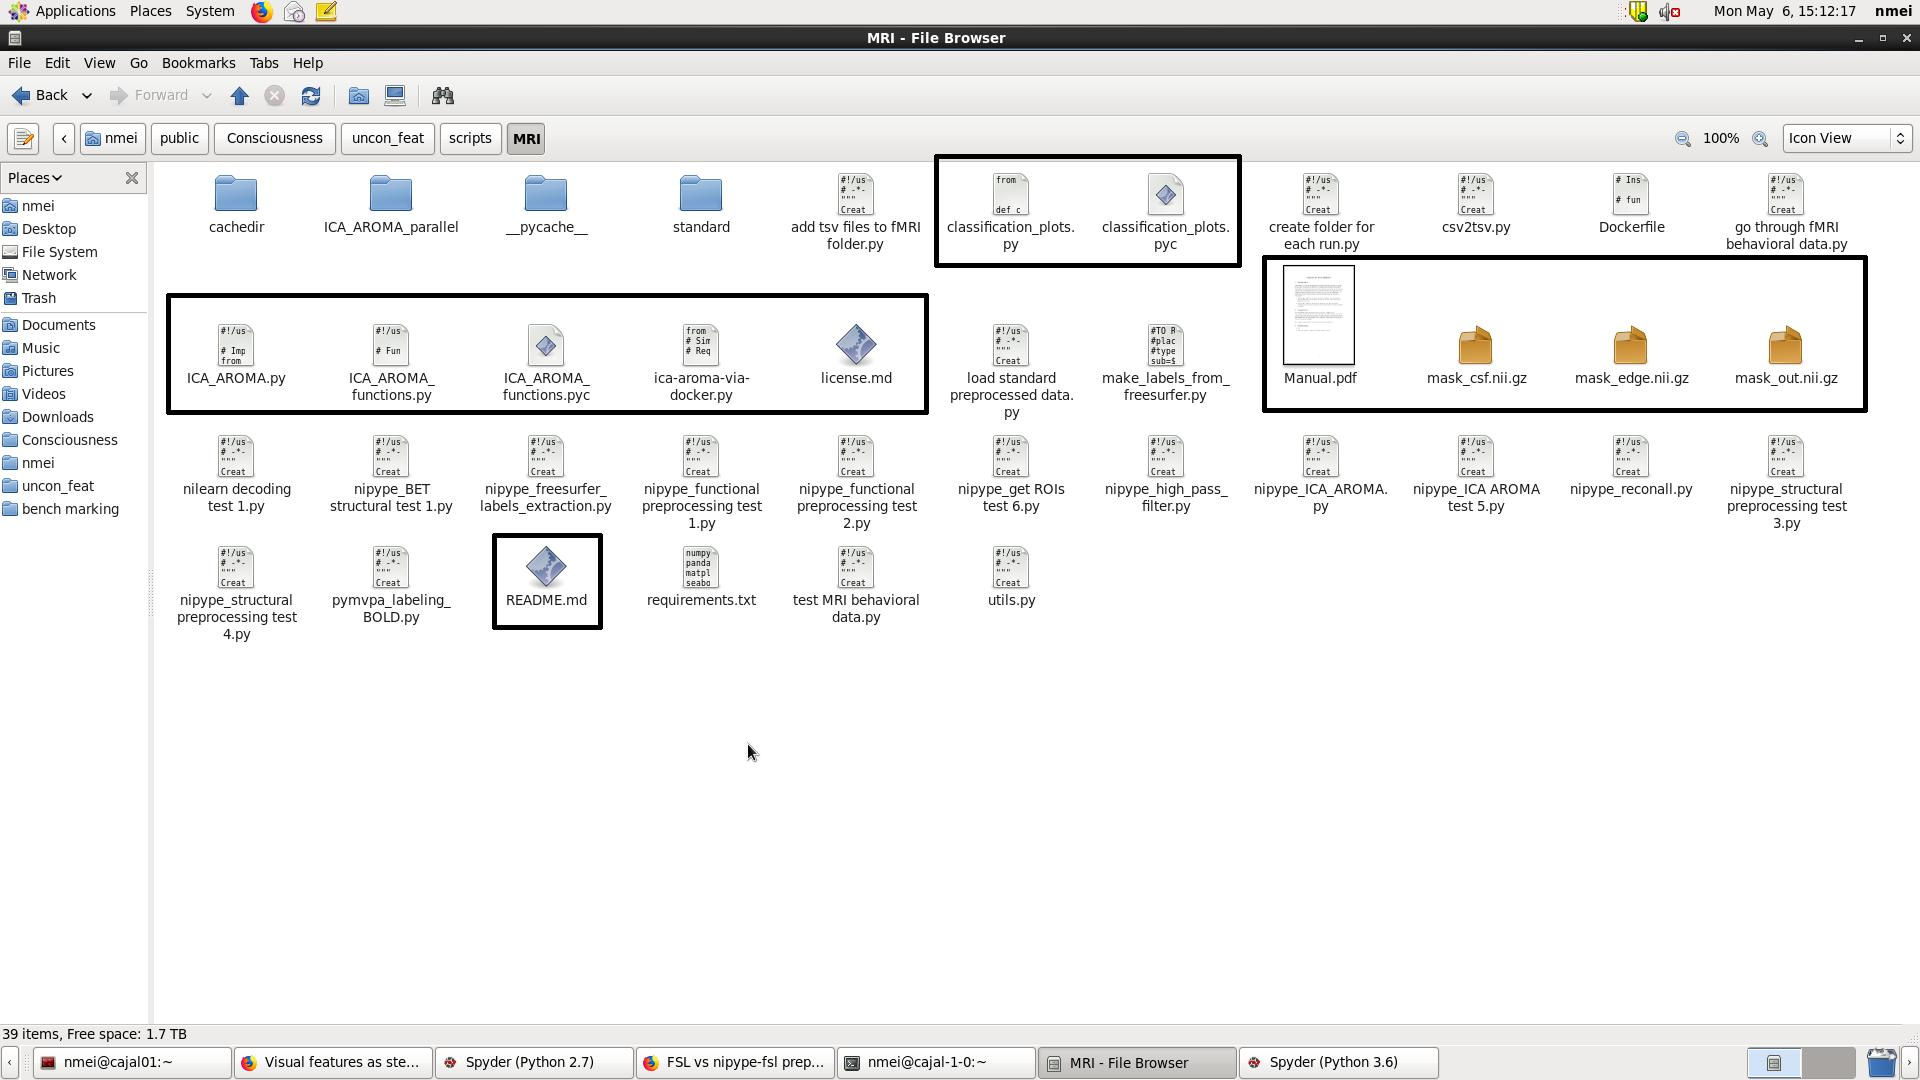

In [0]:
Image('ICA.jpg',height=600)

### 7.6.3. setup the ICA_AROMA script that calls "ICA_AROMA.py"

In [0]:
from nipype.interfaces.fsl import ICA_AROMA
sub = 'sub-01'
fMRI_dir = '{}/func'.format(sub)
if not os.path.exists(fMRI_dir):
    os.makedirs(fMRI_dir)
parent_dir = fMRI_dir
sample = os.path.join(parent_dir,'prefiltered_func.nii.gz') # this is what we called the preprocessed funtional data: [cell](https://colab.research.google.com/drive/19vcwpQ2su92HJ1IMf_spVlPAQ0GKVuyq#scrollTo=QRoEsJBEobjr&line=7&uniqifier=1)


#### codes that cannot be run on colab because we have not run the preprocessing and not saved the preprocessed data
```
first_session           = 2
first_run_dir           = os.path.join(MRI_dir,
                                   'session-0{}'.format(first_session),
                                   'sub-01_unfeat_run-01',)
first_run_dir           = os.path.abspath(first_run_dir)
# setup the ICA_AROMA from nipype
AROMA_obj = ICA_AROMA()
# these two are only found in the very first run
## input the functional to structural transformation matrix
func_to_struct = os.path.join(first_run_dir,'outputs',
                          'reg',
                          'example_func2highres.mat')
## input the warp-file describing the non-linear registration (e.g., FSL FNIRT) of the structural data to MNI152 space
warpfield = os.path.join(first_run_dir,'outputs',
                     'reg',
                     'highres2standard_warp.nii.gz')
# these tow are customized for each run
## input the MCflirt motion correction parameters
fsl_mcflirt_movpar = os.path.join(parent_dir,
                              'func',
                              'MC',
                              'MCflirt.par')
## input the dilate mask
mask = os.path.join(parent_dir,
                'func',
                'mask.nii.gz')
# output directory. If not exists, it will be created automatically. If it exists, you have to specify "over-writing" to ignore the error
output_dir = os.path.join(parent_dir,
                      'func',
                      'ICA_AROMA')
AROMA_obj.inputs.in_file = os.path.abspath(sample)
AROMA_obj.inputs.mat_file = os.path.abspath(func_to_struct)
AROMA_obj.inputs.fnirt_warp_file = os.path.abspath(warpfield)
AROMA_obj.inputs.motion_parameters = os.path.abspath(fsl_mcflirt_movpar)
AROMA_obj.inputs.mask = os.path.abspath(mask)

# Type of denoising strategy: 
# \'no\': only classification, no denoising; 
# \'nonaggr\': non-aggresssive denoising (default); 
# \'aggr\': aggressive denoising; 
# \'both\': both aggressive and non-aggressive denoising (seperately)
AROMA_obj.inputs.denoise_type = 'nonaggr' 

AROMA_obj.inputs.out_dir = os.path.abspath(output_dir)

cmdline = 'python ' + AROMA_obj.cmdline + ' -ow' # overwrite if exists previous ran ICA_AROMA results

print(cmdline)
# use the system line to call the cmdline
os.system(cmdline)
```

### 7.6.4. output file: denoised_func_data_nonaggr.nii.gz

## 7.7. highpass filter

### 7.7.0: the graph for the workflow

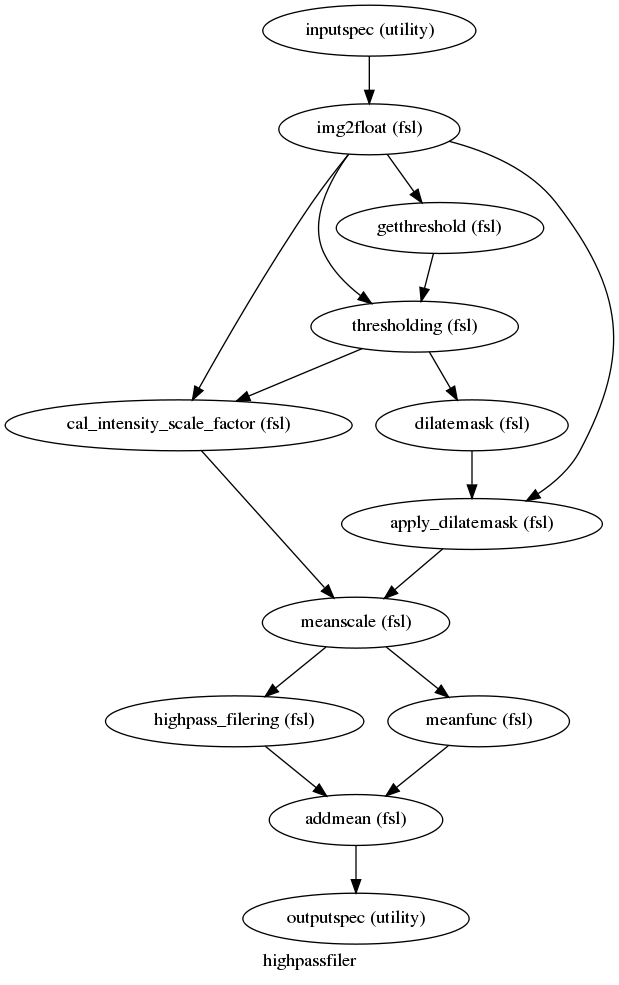

In [0]:
Image('highpass.jpg')

### 7.7.1. calculate the spatial sigma for a given highpass cutoff (in sec) value and a given TR (in sec):



$$highpass = \frac{\frac{hpf_freq}{2}}{TR}$$

### 7.7.2. initialize a workflow

```
from nipype.workflows.fmri.fsl    import preprocess
from nipype.interfaces            import fsl
from nipype.pipeline              import engine as pe
from nipype.interfaces            import utility as util
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')
getthreshop         = preprocess.getthreshop
getmeanscale        = preprocess.getmeanscale
highpass_workflow = pe.Workflow(name = workflow_name)
```



### 7.7.3. input and output nodes



```
inputnode               = pe.Node(interface = util.IdentityInterface(
                                  fields    = ['ICAed_file',]),
                                  name      = 'inputspec')
outputnode              = pe.Node(interface = util.IdentityInterface(
                                  fields    = ['filtered_file']),
                                  name      = 'outputspec')
```



### 7.7.4. image2float: float chart the image data


```
img2float = pe.MapNode(interface    = fsl.ImageMaths(out_data_type     = 'float',
                                                     op_string         = '',
                                                     suffix            = '_dtype'),
                       iterfield    = ['in_file'],
                       name         = 'img2float')
highpass_workflow.connect(inputnode,'ICAed_file',
                          img2float,'in_file')
```
#### *nipype-generated*
```
fslmaths <ICAed_image.nii.gz>  <outupt_in_float_image.nii.gz> -odt float
```
#### *FSL GUI*
```
/opt/fsl/fsl-5.0.9/fsl/bin/fslmaths ICA_AROMA/denoised_func_data_nonaggr prefiltered_func_data -odt float
Total original volumes = 508
```

### 7.7.5. thresholding the image


```
getthreshold = pe.MapNode(interface     = fsl.ImageStats(op_string = '-p 2 -p 98'),
                          iterfield     = ['in_file'],
                          name          = 'getthreshold')
highpass_workflow.connect(img2float,    'out_file',
                          getthreshold, 'in_file')
thresholding = pe.MapNode(interface     = fsl.ImageMaths(out_data_type  = 'char',
                                                         suffix         = '_thresh',
                                                         op_string      = '-Tmin -bin'),
                            iterfield   = ['in_file','op_string'],
                            name        = 'thresholding')
highpass_workflow.connect(img2float,    'out_file',
                          thresholding, 'in_file')
highpass_workflow.connect(getthreshold,('out_stat',getthreshop),
                          thresholding,'op_string')
```

#### *nipype-generated*
```
fslstats <image_in_float.nii.gz> -p 2 -p 98
fslmaths <image_in_float.nii.gz> -thr 1729.0583984000 -Tmin -bin <binarized_image_mask.nii.gz> -odt char
```
#### *FSL GUI*
```
/opt/fsl/fsl-5.0.9/fsl/bin/fslstats prefiltered_func_data -p 2 -p 98
/opt/fsl/fsl-5.0.9/fsl/bin/fslmaths prefiltered_func_data -thr 1617.8395508 -Tmin -bin mask -odt char
```

### 7.7.6. dilatemasking

```
dilatemask = pe.MapNode(interface   = fsl.ImageMaths(suffix     = '_dil',
                                                     op_string  = '-dilF'),
                        iterfield   = ['in_file'],
                        name        = 'dilatemask')
highpass_workflow.connect(thresholding,'out_file',
                          dilatemask,'in_file')
```
#### *nipype-generated*

```
fslmaths <mask.nii.gz> -dilF <dilatemask.nii.gz>
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.9/fsl/bin/fslmaths mask -dilF mask
```

### 7.7.7. masking

```
maskfunc = pe.MapNode(interface     = fsl.ImageMaths(suffix     = '_mask',
                                                     op_string  = '-mas'),
                      iterfield     = ['in_file','in_file2'],
                      name          = 'apply_dilatemask')
highpass_workflow.connect(img2float,    'out_file',
                          maskfunc,     'in_file')
highpass_workflow.connect(dilatemask,   'out_file',
                          maskfunc,     'in_file2')
```
#### *nipype-generated*
```
fslmaths <image_in_float.nii.gz> -mas <dilatemask.nii.gz>
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.9/fsl/bin/fslmaths prefiltered_func_data -mas mask prefiltered_func_data_thresh
```




### 7.7.8. calculate median value of the functional images across time: input image would all the volumes, and there is also a mask image we get from the thresholding (10% of the upper bound)

```
medianval = pe.MapNode(interface    = fsl.ImageStats(op_string = '-k %s -p 50'),
                       iterfield    = ['in_file','mask_file'],
                       name         = 'cal_intensity_scale_factor')
highpass_workflow.connect(img2float,    'out_file',
                          medianval,    'in_file')
highpass_workflow.connect(thresholding, 'out_file',
                          medianval,    'mask_file')
```

#### *nipype-generated*
```
fslstats <image_in_float.nii.gz> -k <thresholding_mask.nii.gz> -p 50
```

#### *FSL GUI*

```
/opt/fsl/fsl-5.0.9/fsl/bin/fslstats prefiltered_func_data -k mask -p 50
```

### 7.7.9. meanscale

```
meanscale = pe.MapNode(interface    = fsl.ImageMaths(suffix = '_intnorm'),
                       iterfield    = ['in_file','op_string'],
                       name         = 'meanscale')
highpass_workflow.connect(maskfunc,     'out_file',
                          meanscale,    'in_file')
highpass_workflow.connect(medianval,    ('out_stat',getmeanscale),
                          meanscale,    'op_string')
```


#### *nipype-generated*

```
fslmaths <thresholded_image.nii.gz> -mul 0.9933852571 <output.nii.gz>
```
#### *FSL GUI*
```
/opt/fsl/fsl-5.0.9/fsl/bin/fslmaths prefiltered_func_data_thresh -mul 1.06308197635 prefiltered_func_data_intnorm
```


### 7.7.10. calculate the mean image.nii.gz across time

```
meanfunc = pe.MapNode(interface     = fsl.ImageMaths(suffix     = '_mean',
                                                     op_string  = '-Tmean'),
                       iterfield    = ['in_file'],
                       name         = 'meanfunc')
highpass_workflow.connect(meanscale, 'out_file',
                          meanfunc,  'in_file')
```
#### *nipype-generated*
```
fslmaths <mean_scaled_image.nii.gz> -Tmean <mean.nii.gz>
```
#### *FSL GUI*
```
/opt/fsl/fsl-5.0.9/fsl/bin/fslmaths prefiltered_func_data_intnorm -Tmean tempMean
```

### 7.7.11. apply the temporal highpass filer and then add the mean back to the filtered images

```
hpf = pe.MapNode(interface  = fsl.ImageMaths(suffix     = '_tempfilt',
                                             op_string  = '-bptf %.10f -1' % (HP_freq/2/TR)),
                 iterfield  = ['in_file'],
                 name       = 'highpass_filering')
highpass_workflow.connect(meanscale,'out_file',
                          hpf,      'in_file',)

addMean = pe.MapNode(interface  = fsl.BinaryMaths(operation = 'add'),
                     iterfield  = ['in_file','operand_file'],
                     name       = 'addmean')
highpass_workflow.connect(hpf,      'out_file',
                          addMean,  'in_file')
highpass_workflow.connect(meanfunc, 'out_file',
                          addMean,  'operand_file')
```
#### *nipype-generated*
```
fslmaths <mean_scaled_image.nii.gz> 
-bptf 35.2941176471 -1 # 35.295176471 = (60 / 2) / 0.85 = (hpf in sec / 2) / TR
<filtered.nii.gz>

fslmaths <filtered.nii.gz> -add <mean.nii.gz>
```
#### *FSL GUI*
```
/opt/fsl/fsl-5.0.9/fsl/bin/fslmaths prefiltered_func_data_intnorm -bptf 35.2941176471 -1 -add tempMean prefiltered_func_data_tempfilt
```

### 7.7.12. connect the last output to the output node and run the workflow

```
highpass_workflow.connect(addMean,      'out_file',
                          outputnode,   'filtered_file')
# define the necessary configurations for a nipype workflow: base_dir, input, output
highpass_workflow.base_dir = 'hpf'
highpass_workflow.write_graph(dotfilename='session {} run {}.dot'.format(n_session,n_run))

highpass_workflow.inputs.inputspec.ICAed_file = os.path.abspath(file_name)
highpass_workflow.inputs.addmean.out_file = os.path.abspath(os.path.join(output_dir,
                                                                                 'filtered.nii.gz'))

highpass_workflow.run()
```

# 8. registration structural to example_func, structural to standard, standard to example_func

## 8.1. function to create a registration workflow

In [0]:
def create_registration_workflow(
                                 anat_brain,
                                 anat_head,
                                 example_func,
                                 standard_brain,
                                 standard_head,
                                 standard_mask,
                                 workflow_name = 'registration',
                                 output_dir = 'temp'):
    from nipype.interfaces          import fsl
    from nipype.interfaces         import utility as util
    from nipype.pipeline           import engine as pe
    fsl.FSLCommand.set_default_output_type('NIFTI_GZ')
    registration                    = pe.Workflow(name = 'registration')
    inputnode                       = pe.Node(
                                        interface   = util.IdentityInterface(
                                        fields      = [
                                                'highres', # anat_brain
                                                'highres_head', # anat_head
                                                'example_func',
                                                'standard', # standard_brain
                                                'standard_head',
                                                'standard_mask'
                                                ]),
                                        name        = 'inputspec')
    outputnode                      = pe.Node(
                                    interface   = util.IdentityInterface(
                                    fields      = ['example_func2highres_nii_gz',
                                                   'example_func2highres_mat',
                                                   'linear_example_func2highres_log',
                                                   'highres2example_func_mat',
                                                   'highres2standard_linear_nii_gz',
                                                   'highres2standard_mat',
                                                   'linear_highres2standard_log',
                                                   'highres2standard_nii_gz',
                                                   'highres2standard_warp_nii_gz',
                                                   'highres2standard_head_nii_gz',
    #                                               'highres2standard_apply_warp_nii_gz',
                                                   'highres2highres_jac_nii_gz',
                                                   'nonlinear_highres2standard_log',
                                                   'highres2standard_nii_gz',
                                                   'standard2highres_mat',
                                                   'example_func2standard_mat',
                                                   'example_func2standard_warp_nii_gz',
                                                   'example_func2standard_nii_gz',
                                                   'standard2example_func_mat',
                                                   ]),
                                    name        = 'outputspec')
    """
    fslmaths /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/anat/sub-01-T1W_mprage_sag_p2_1iso_MGH_day_6_nipy_brain highres
    fslmaths /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/anat/sub-01-T1W_mprage_sag_p2_1iso_MGH_day_6_nipy_brain  highres_head
    fslmaths /opt/fsl/fsl-5.0.9/fsl/data/standard/MNI152_T1_2mm_brain standard
    fslmaths /opt/fsl/fsl-5.0.9/fsl/data/standard/MNI152_T1_2mm standard_head
    fslmaths /opt/fsl/fsl-5.0.9/fsl/data/standard/MNI152_T1_2mm_brain_mask_dil standard_mask
    """
    # skip
    
    """
    /opt/fsl/fsl-5.0.10/fsl/bin/flirt 
        -in example_func 
        -ref highres 
        -out example_func2highres 
        -omat example_func2highres.mat 
        -cost corratio 
        -dof 7 
        -searchrx -180 180 
        -searchry -180 180 
        -searchrz -180 180 
        -interp trilinear 
    """
    linear_example_func2highres = pe.MapNode(
            interface   = fsl.FLIRT(cost = 'corratio',
                                    interp = 'trilinear',
                                    dof = 7,
                                    save_log = True,
                                    searchr_x = [-180, 180],
                                    searchr_y = [-180, 180],
                                    searchr_z = [-180, 180],),
            iterfield   = ['in_file','reference'],
            name        = 'linear_example_func2highres')
    registration.connect(inputnode, 'example_func',
                         linear_example_func2highres, 'in_file')
    registration.connect(inputnode, 'highres',
                         linear_example_func2highres, 'reference')
    registration.connect(linear_example_func2highres, 'out_file',
                         outputnode, 'example_func2highres_nii_gz')
    registration.connect(linear_example_func2highres, 'out_matrix_file',
                         outputnode, 'example_func2highres_mat')
    registration.connect(linear_example_func2highres, 'out_log',
                         outputnode, 'linear_example_func2highres_log')
    
    """
    /opt/fsl/fsl-5.0.10/fsl/bin/convert_xfm 
        -inverse -omat highres2example_func.mat example_func2highres.mat
    """
    get_highres2example_func = pe.MapNode(
            interface = fsl.ConvertXFM(invert_xfm = True),
            iterfield = ['in_file'],
            name = 'get_highres2example_func')
    registration.connect(linear_example_func2highres,'out_matrix_file',
                         get_highres2example_func,'in_file')
    registration.connect(get_highres2example_func,'out_file',
                         outputnode,'highres2example_func_mat')
    
    """
    /opt/fsl/fsl-5.0.10/fsl/bin/flirt 
        -in highres 
        -ref standard 
        -out highres2standard 
        -omat highres2standard.mat 
        -cost corratio 
        -dof 12 
        -searchrx -180 180 
        -searchry -180 180 
        -searchrz -180 180 
        -interp trilinear 
    """
    linear_highres2standard = pe.MapNode(
            interface = fsl.FLIRT(cost = 'corratio',
                                interp = 'trilinear',
                                dof = 12,
                                save_log = True,
                                searchr_x = [-180, 180],
                                searchr_y = [-180, 180],
                                searchr_z = [-180, 180],),
            iterfield = ['in_file','reference'],
            name = 'linear_highres2standard')
    registration.connect(inputnode,'highres',
                         linear_highres2standard,'in_file')
    registration.connect(inputnode,'standard',
                         linear_highres2standard,'reference',)
    registration.connect(linear_highres2standard,'out_file',
                         outputnode,'highres2standard_linear_nii_gz')
    registration.connect(linear_highres2standard,'out_matrix_file',
                         outputnode,'highres2standard_mat')
    registration.connect(linear_highres2standard,'out_log',
                         outputnode,'linear_highres2standard_log')
    """
    /opt/fsl/fsl-5.0.10/fsl/bin/fnirt 
        --iout=highres2standard_head 
        --in=highres_head 
        --aff=highres2standard.mat 
        --cout=highres2standard_warp 
        --iout=highres2standard 
        --jout=highres2highres_jac 
        --config=T1_2_MNI152_2mm 
        --ref=standard_head 
        --refmask=standard_mask 
        --warpres=10,10,10
    """
    nonlinear_highres2standard = pe.MapNode(
            interface = fsl.FNIRT(warp_resolution = (10,10,10),
                                  config_file = "T1_2_MNI152_2mm"),
            iterfield = ['in_file','ref_file','affine_file','refmask_file'],
            name = 'nonlinear_highres2standard')
    # -- iout
    registration.connect(nonlinear_highres2standard,'warped_file',
                         outputnode,'highres2standard_head_nii_gz')
    # --in
    registration.connect(inputnode,'highres',
                         nonlinear_highres2standard,'in_file')
    # --aff
    registration.connect(linear_highres2standard,'out_matrix_file',
                         nonlinear_highres2standard,'affine_file')
    # --cout
    registration.connect(nonlinear_highres2standard,'fieldcoeff_file',
                         outputnode,'highres2standard_warp_nii_gz')
    # --jout
    registration.connect(nonlinear_highres2standard,'jacobian_file',
                         outputnode,'highres2highres_jac_nii_gz')
    # --ref
    registration.connect(inputnode,'standard_head',
                         nonlinear_highres2standard,'ref_file',)
    # --refmask
    registration.connect(inputnode,'standard_mask',
                         nonlinear_highres2standard,'refmask_file')
    # log
    registration.connect(nonlinear_highres2standard,'log_file',
                         outputnode,'nonlinear_highres2standard_log')
    """
    /opt/fsl/fsl-5.0.10/fsl/bin/applywarp 
        -i highres 
        -r standard 
        -o highres2standard 
        -w highres2standard_warp
    """
    warp_highres2standard = pe.MapNode(
            interface = fsl.ApplyWarp(),
            iterfield = ['in_file','ref_file','field_file'],
            name = 'warp_highres2standard')
    registration.connect(inputnode,'highres',
                         warp_highres2standard,'in_file')
    registration.connect(inputnode,'standard',
                         warp_highres2standard,'ref_file')
    registration.connect(warp_highres2standard,'out_file',
                         outputnode,'highres2standard_nii_gz')
    registration.connect(nonlinear_highres2standard,'fieldcoeff_file',
                         warp_highres2standard,'field_file')
    """
    /opt/fsl/fsl-5.0.10/fsl/bin/convert_xfm 
        -inverse -omat standard2highres.mat highres2standard.mat
    """
    get_standard2highres = pe.MapNode(
            interface = fsl.ConvertXFM(invert_xfm = True),
            iterfield = ['in_file'],
            name = 'get_standard2highres')
    registration.connect(linear_highres2standard,'out_matrix_file',
                         get_standard2highres,'in_file')
    registration.connect(get_standard2highres,'out_file',
                         outputnode,'standard2highres_mat')
    """
    /opt/fsl/fsl-5.0.10/fsl/bin/convert_xfm 
        -omat example_func2standard.mat -concat highres2standard.mat example_func2highres.mat
    """
    get_exmaple_func2standard = pe.MapNode(
            interface = fsl.ConvertXFM(concat_xfm = True),
            iterfield = ['in_file','in_file2'],
            name = 'get_exmaple_func2standard')
    registration.connect(linear_example_func2highres, 'out_matrix_file',
                         get_exmaple_func2standard,'in_file')
    registration.connect(linear_highres2standard,'out_matrix_file',
                         get_exmaple_func2standard,'in_file2')
    registration.connect(get_exmaple_func2standard,'out_file',
                         outputnode,'example_func2standard_mat')
    """
    /opt/fsl/fsl-5.0.10/fsl/bin/convertwarp 
        --ref=standard 
        --premat=example_func2highres.mat 
        --warp1=highres2standard_warp 
        --out=example_func2standard_warp
    """
    convertwarp_example2standard = pe.MapNode(
            interface = fsl.ConvertWarp(),
            iterfield = ['reference','premat','warp1'],
            name = 'convertwarp_example2standard')
    registration.connect(inputnode,'standard',
                         convertwarp_example2standard,'reference')
    registration.connect(linear_example_func2highres,'out_matrix_file',
                         convertwarp_example2standard,'premat')
    registration.connect(nonlinear_highres2standard,'fieldcoeff_file',
                         convertwarp_example2standard,'warp1')
    registration.connect(convertwarp_example2standard,'out_file',
                         outputnode,'example_func2standard_warp_nii_gz')
    """
    /opt/fsl/fsl-5.0.10/fsl/bin/applywarp 
        --ref=standard 
        --in=example_func 
        --out=example_func2standard 
        --warp=example_func2standard_warp
    """
    warp_example2stand = pe.MapNode(
            interface = fsl.ApplyWarp(),
            iterfield = ['ref_file','in_file','field_file'],
            name = 'warp_example2stand')
    registration.connect(inputnode,'standard',
                         warp_example2stand,'ref_file')
    registration.connect(inputnode,'example_func',
                         warp_example2stand,'in_file')
    registration.connect(warp_example2stand,'out_file',
                         outputnode,'example_func2standard_nii_gz')
    registration.connect(convertwarp_example2standard,'out_file',
                         warp_example2stand,'field_file')
    """
    /opt/fsl/fsl-5.0.10/fsl/bin/convert_xfm 
        -inverse -omat standard2example_func.mat example_func2standard.mat
    """
    get_standard2example_func = pe.MapNode(
            interface = fsl.ConvertXFM(invert_xfm = True),
            iterfield = ['in_file'],
            name = 'get_standard2example_func')
    registration.connect(get_exmaple_func2standard,'out_file',
                         get_standard2example_func,'in_file')
    registration.connect(get_standard2example_func,'out_file',
                         outputnode,'standard2example_func_mat')
    
    registration.base_dir = output_dir
    
    registration.inputs.inputspec.highres = anat_brain
    registration.inputs.inputspec.highres_head= anat_head
    registration.inputs.inputspec.example_func = example_func
    registration.inputs.inputspec.standard = standard_brain
    registration.inputs.inputspec.standard_head = standard_head
    registration.inputs.inputspec.standard_mask = standard_mask
    
    # define all the oupput file names with the directory
    registration.inputs.linear_example_func2highres.out_file          = os.path.abspath(os.path.join(output_dir,
                            'example_func2highres.nii.gz'))
    registration.inputs.linear_example_func2highres.out_matrix_file   = os.path.abspath(os.path.join(output_dir,
                            'example_func2highres.mat'))
    registration.inputs.linear_example_func2highres.out_log           = os.path.abspath(os.path.join(output_dir,
                            'linear_example_func2highres.log'))
    registration.inputs.get_highres2example_func.out_file        = os.path.abspath(os.path.join(output_dir,
                            'highres2example_func.mat'))
    registration.inputs.linear_highres2standard.out_file         = os.path.abspath(os.path.join(output_dir,
                            'highres2standard_linear.nii.gz'))
    registration.inputs.linear_highres2standard.out_matrix_file  = os.path.abspath(os.path.join(output_dir,
                            'highres2standard.mat'))
    registration.inputs.linear_highres2standard.out_log          = os.path.abspath(os.path.join(output_dir,
                            'linear_highres2standard.log'))
    # --iout
    registration.inputs.nonlinear_highres2standard.warped_file  = os.path.abspath(os.path.join(output_dir,
                            'highres2standard.nii.gz'))
    # --cout
    registration.inputs.nonlinear_highres2standard.fieldcoeff_file    = os.path.abspath(os.path.join(output_dir,
                            'highres2standard_warp.nii.gz'))
    # --jout
    registration.inputs.nonlinear_highres2standard.jacobian_file      = os.path.abspath(os.path.join(output_dir,
                            'highres2highres_jac.nii.gz'))
    registration.inputs.nonlinear_highres2standard.log_file           = os.path.abspath(os.path.join(output_dir,
                            'nonlinear_highres2standard.log'))
    registration.inputs.warp_highres2standard.out_file                = os.path.abspath(os.path.join(output_dir,
                            'highres2standard.nii.gz'))
    registration.inputs.get_standard2highres.out_file       = os.path.abspath(os.path.join(output_dir,
                            'standard2highres.mat'))
    registration.inputs.get_exmaple_func2standard.out_file               = os.path.abspath(os.path.join(output_dir,
                            'example_func2standard.mat'))
    registration.inputs.convertwarp_example2standard.out_file     = os.path.abspath(os.path.join(output_dir,
                            'example_func2standard_warp.nii.gz'))
    registration.inputs.warp_example2stand.out_file       = os.path.abspath(os.path.join(output_dir,
                            'example_func2standard.nii.gz'))
    registration.inputs.get_standard2example_func.out_file       = os.path.abspath(os.path.join(output_dir,
                            'standard2example_func.mat'))
    return registration

## 8.2. call the function to create the workflow

In [0]:
import os
func_dir = ''
anat_dir = '../../data/MRI/{}/anat/'
ref_dir = 'example_func.nii.gz'
standard_brain = 'MNI152_T1_2mm_brain.nii.gz'
standard_head = 'MNI152_T1_2mm.nii.gz'
standard_mask = 'MNI152_T1_2mm_brain_mask_dil.nii.gz'

sub = 'sub-01'
anat_brain = 'T1_brain.nii'
anat_head = 'T1.nii'
func_ref = ref_dir.format(sub,'02',sub,'01')

session = '02'
run = '01'

registration = create_registration_workflow(
    anat_brain = anat_brain,
    anat_head = anat_head,
    example_func = func_ref,
    standard_brain = standard_brain,
    standard_head = standard_head,
    standard_mask = standard_mask,
    workflow_name = 'registration')

output_dir = 'tmp'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)



registration.write_graph()

190715-19:20:58,86 nipype.workflow INFO:
	 Generated workflow graph: temp/registration/graph.png (graph2use=hierarchical, simple_form=True).


'temp/registration/graph.png'

## 8.3. plot the workflow

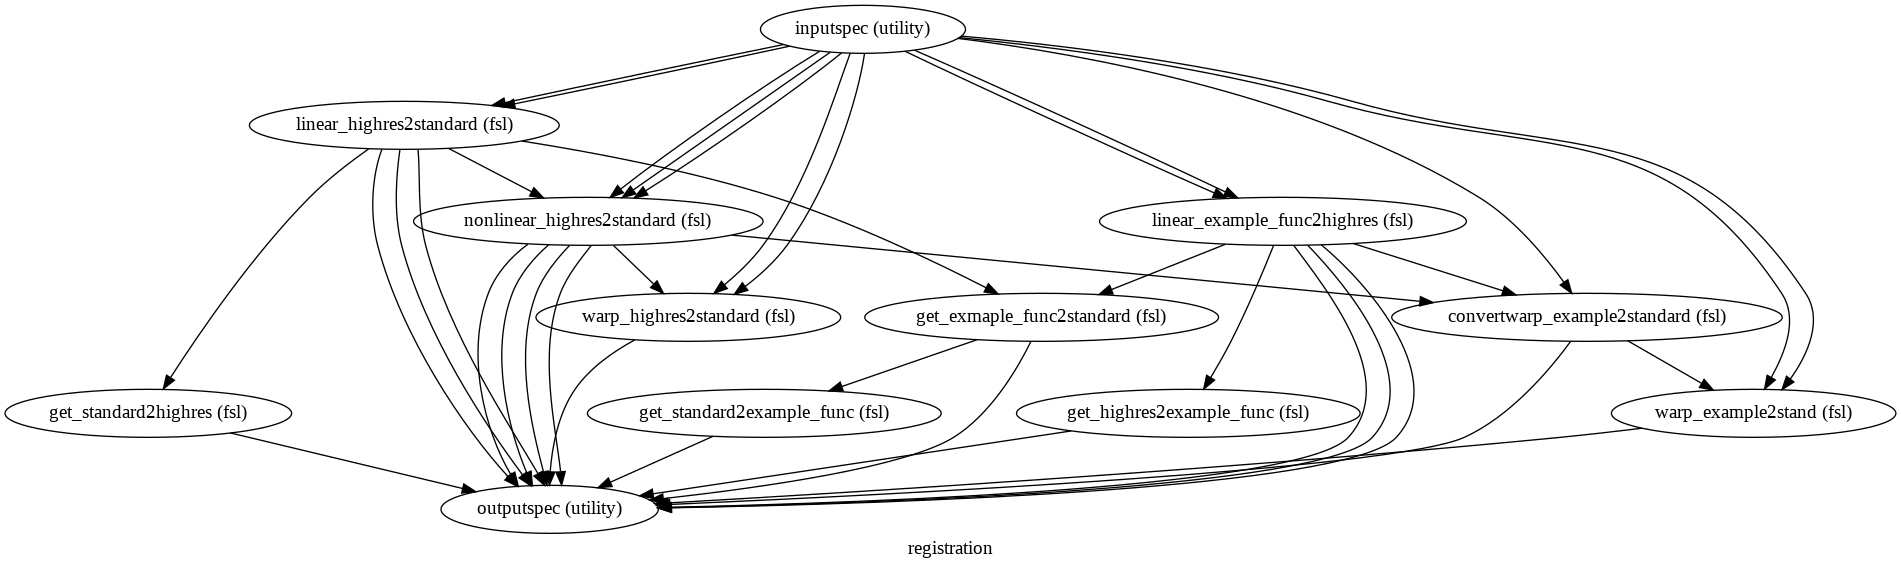

In [0]:
Image(os.path.join('temp/registration/graph.png'),width=800)

## 8.4. How do we map the nipype function to the FSL GUI commands?

### 8.4.1. initialize the input and output spaces
```
inputnode                       = pe.Node(
                                        interface   = util.IdentityInterface(
                                        fields      = [
                                                'highres', # anat_brain BET T1
                                                'highres_head', # anat_head 
                                                'example_func',
                                                'standard', # standard_brain
                                                'standard_head',
                                                'standard_mask'
                                                ]),
                                        name        = 'inputspec')
    outputnode                      = pe.Node(
                                    interface   = util.IdentityInterface(
                                    fields      = ['example_func2highres_nii_gz',
                                                   'example_func2highres_mat',
                                                   'linear_example_func2highres_log',
                                                   'highres2example_func_mat',
                                                   'highres2standard_linear_nii_gz',
                                                   'highres2standard_mat',
                                                   'linear_highres2standard_log',
                                                   'highres2standard_nii_gz',
                                                   'highres2standard_warp_nii_gz',
                                                   'highres2standard_head_nii_gz',
    #                                               'highres2standard_apply_warp_nii_gz',
                                                   'highres2highres_jac_nii_gz',
                                                   'nonlinear_highres2standard_log',
                                                   'highres2standard_nii_gz',
                                                   'standard2highres_mat',
                                                   'example_func2standard_mat',
                                                   'example_func2standard_warp_nii_gz',
                                                   'example_func2standard_nii_gz',
                                                   'standard2example_func_mat',
                                                   ]),
                                    name        = 'outputspec')
```

#### 8.4.1.1. moving things around in FSL, but I would just skip these because I could simply specify those images with `os`

**FSL commands**
```
fslmaths /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/anat/sub-01-T1W_mprage_sag_p2_1iso_MGH_day_6_nipy_brain highres
fslmaths /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/anat/sub-01-T1W_mprage_sag_p2_1iso_MGH_day_6_nipy_brain  highres_head
fslmaths /opt/fsl/fsl-5.0.9/fsl/data/standard/MNI152_T1_2mm_brain standard
fslmaths /opt/fsl/fsl-5.0.9/fsl/data/standard/MNI152_T1_2mm standard_head
fslmaths /opt/fsl/fsl-5.0.9/fsl/data/standard/MNI152_T1_2mm_brain_mask_dil standard_mask

```

**We can do the same thing with nipype:**
```
fslmaths = fsl.ImageMaths()
fslmaths.inputs.in_file = anat_brain
fslmaths.inputs.out_file = os.path.abspath(os.path.join(output_dir,'highres.nii.gz'))
fslmaths.cmdline
fslmaths.run()

fslmaths = fsl.ImageMaths()
fslmaths.inputs.in_file = anat_head
fslmaths.inputs.out_file = os.path.abspath(os.path.join(output_dir,'highres_head.nii.gz'))
fslmaths.cmdline
fslmaths.run()

fslmaths = fsl.ImageMaths()
fslmaths.inputs.in_file = standard_brain
fslmaths.inputs.out_file = os.path.abspath(os.path.join(output_dir,'standard.nii.gz'))
fslmaths.cmdline
fslmaths.run()

fslmaths = fsl.ImageMaths()
fslmaths.inputs.in_file = standard_head
fslmaths.inputs.out_file = os.path.abspath(os.path.join(output_dir,'standard_head.nii.gz'))
fslmaths.cmdline
fslmaths.run()

fslmaths = fsl.ImageMaths()
fslmaths.inputs.in_file = standard_mask
fslmaths.inputs.out_file = os.path.abspath(os.path.join(output_dir,'standard_mask.nii.gz'))
fslmaths.cmdline
fslmaths.run()
```

### 8.4.2. example2highres_flirt: FLIRT mapping from example_func to T1 (was wrong but now correct for x, y, z range of search)
```
linear_example_func2highres = pe.MapNode(
        interface   = fsl.FLIRT(cost = 'corratio',
                                interp = 'trilinear',
                                dof = 7,
                                save_log = True,
                                searchr_x = [-180, 180],
                                searchr_y = [-180, 180],
                                searchr_z = [-180, 180],),
        iterfield   = ['in_file','reference'],
        name        = 'linear_example_func2highres')
registration.connect(inputnode, 'example_func',
                     linear_example_func2highres, 'in_file')
registration.connect(inputnode, 'highres',
                     linear_example_func2highres, 'reference')
registration.connect(linear_example_func2highres, 'out_file',
                     outputnode, 'example_func2highres_nii_gz')
registration.connect(linear_example_func2highres, 'out_matrix_file',
                     outputnode, 'example_func2highres_mat')
registration.connect(linear_example_func2highres, 'out_log',
                     outputnode, 'linear_example_func2highres_log')
```

#### *nipype-generated*
```
flirt 
 -in example_func.nii.gz 
 -ref T1.nii.gz 
 -out example_func2highres.nii.gz 
 -omat example_func2highres.mat 
 -cost corratio 
 -dof 7 
 -interp trilinear 
 -searchrx -180 180 
 -searchry -180 180 
 -searchrz -180 180 
 -verbose 1
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/flirt 
    -in example_func # <input.nii>
    -ref highres  # <map_to_image.nii>
    -out example_func2highres  # ? an image.nii.gz?
    -omat example_func2highres.mat # transformation matrix
    -cost corratio 
    -dof 7 
    -searchrx -180 180 
    -searchry -180 180 
    -searchrz -180 180 
    -interp trilinear 
```


### 8.4.3. inverse_example2highres: get inverse transformation matrix
```
get_highres2example_func = pe.MapNode(
            interface = fsl.ConvertXFM(invert_xfm = True),
            iterfield = ['in_file'],
            name = 'get_highres2example_func')
    registration.connect(linear_example_func2highres,'out_matrix_file',
                         get_highres2example_func,'in_file')
    registration.connect(get_highres2example_func,'out_file',
                         outputnode,'highres2example_func_mat')
```
#### *nipype-generated*
```
convert_xfm 
-omat /reg/highres2example_func.mat 
-inverse /reg/example_func2highres.mat
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/convert_xfm 
    -inverse -omat highres2example_func.mat example_func2highres.mat
```

### 8.4.4. highres2standard_flirt: map structural image to standard, thus, it takes 12 degree of freedom
```
linear_highres2standard = pe.MapNode(
        interface = fsl.FLIRT(cost = 'corratio',
                            interp = 'trilinear',
                            dof = 12,
                            save_log = True,
                            searchr_x = [-180, 180],
                            searchr_y = [-180, 180],
                            searchr_z = [-180, 180],),
        iterfield = ['in_file','reference'],
        name = 'linear_highres2standard')
registration.connect(inputnode,'highres',
                     linear_highres2standard,'in_file')
registration.connect(inputnode,'standard',
                     linear_highres2standard,'reference',)
registration.connect(linear_highres2standard,'out_file',
                     outputnode,'highres2standard_linear_nii_gz')
registration.connect(linear_highres2standard,'out_matrix_file',
                     outputnode,'highres2standard_mat')
registration.connect(linear_highres2standard,'out_log',
                     outputnode,'linear_highres2standard_log')
```

#### *nipype-generated*
```
flirt 
 -in /standard/MNI152_T1_2mm_brain.nii.gz 
 -out /reg/highres2standard.nii.gz 
 -omat /reg/highres2standard.mat 
 -cost corratio 
 -dof 12 
 -interp trilinear 
 -searchrx -180 180 
 -searchry -180 180 
 -searchrz -180 180 
 -verbose 1
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/flirt 
    -in highres 
    -ref standard 
    -out highres2standard 
    -omat highres2standard.mat 
    -cost corratio 
    -dof 12 
    -searchrx -180 180 
    -searchry -180 180 
    -searchrz -180 180 
    -interp trilinear
```



### 8.4.5. highres2standard_fnirt: nonlinear mapping from structural to standard
```
nonlinear_highres2standard = pe.MapNode(
        interface = fsl.FNIRT(warp_resolution = (10,10,10),
                              config_file = "T1_2_MNI152_2mm"),
        iterfield = ['in_file','ref_file','affine_file','refmask_file'],
        name = 'nonlinear_highres2standard')
# -- iout
registration.connect(nonlinear_highres2standard,'warped_file',
                     outputnode,'highres2standard_head_nii_gz')
# --in
registration.connect(inputnode,'highres',
                     nonlinear_highres2standard,'in_file')
# --aff
registration.connect(linear_highres2standard,'out_matrix_file',
                     nonlinear_highres2standard,'affine_file')
# --cout
registration.connect(nonlinear_highres2standard,'fieldcoeff_file',
                     outputnode,'highres2standard_warp_nii_gz')
# --jout
registration.connect(nonlinear_highres2standard,'jacobian_file',
                     outputnode,'highres2highres_jac_nii_gz')
# --ref
registration.connect(inputnode,'standard_head',
                     nonlinear_highres2standard,'ref_file',)
# --refmask
registration.connect(inputnode,'standard_mask',
                     nonlinear_highres2standard,'refmask_file')
# log
registration.connect(nonlinear_highres2standard,'log_file',
                     outputnode,'nonlinear_highres2standard_log')
```

#### *nipype-generated*
```
fnirt 
 --aff=/reg/highres2standard.mat 
 --config=T1_2_MNI152_2mm 
 --cout=/reg/highres2standard_warp.nii.gz 
 --in=T1.nii 
 --jout=/reg/highres2highres_jac.nii.gz 
 --logout=log.txt 
 --ref=/standard/MNI152_T1_2mm.nii.gz 
 --refmask=/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz 
 --warpres=10,10,10 
 --iout=highres2standard_head.nii.gz
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/fnirt 
    --iout=highres2standard_head 
    --in=highres_head 
    --aff=highres2standard.mat 
    --cout=highres2standard_warp 
    --iout=highres2standard 
    --jout=highres2highres_jac 
    --config=T1_2_MNI152_2mm 
    --ref=standard_head 
    --refmask=standard_mask 
    --warpres=10,10,10
```

### 8.4.6. warp_highres2standard:
```
warp_highres2standard = pe.MapNode(
        interface = fsl.ApplyWarp(),
        iterfield = ['in_file','ref_file','field_file'],
        name = 'warp_highres2standard')
registration.connect(inputnode,'highres',
                     warp_highres2standard,'in_file')
registration.connect(inputnode,'standard',
                     warp_highres2standard,'ref_file')
registration.connect(warp_highres2standard,'out_file',
                     outputnode,'highres2standard_nii_gz')
registration.connect(nonlinear_highres2standard,'fieldcoeff_file',
                     warp_highres2standard,'field_file')
```
#### *nipype-generate*
```
applywarp 
 --in=T1.nii.gz 
 --ref=/standard/MNI152_T1_2mm_brain.nii.gz 
 --out=/reg/highres2standard.nii.gz 
 --warp=/reg/highres2standard_warp.nii.gz
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/applywarp 
    -i highres 
    -r standard 
    -o highres2standard 
    -w highres2standard_warp
```

### 8.4.7. inverse_highres2standard:
```
get_standard2highres = pe.MapNode(
        interface = fsl.ConvertXFM(invert_xfm = True),
        iterfield = ['in_file'],
        name = 'get_standard2highres')
registration.connect(linear_highres2standard,'out_matrix_file',
                     get_standard2highres,'in_file')
registration.connect(get_standard2highres,'out_file',
                     outputnode,'standard2highres_mat')
```
#### *nipype-generate*
```
convert_xfm 
-omat /reg/standard2highres.mat 
-inverse /reg/highres2standard.mat
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/convert_xfm 
    -inverse -omat standard2highres.mat highres2standard.mat
```

### 8.4.8. example2standard - surprisingly, the order of file1 and file2 is important:
```
get_exmaple_func2standard = pe.MapNode(
        interface = fsl.ConvertXFM(concat_xfm = True),
        iterfield = ['in_file','in_file2'],
        name = 'get_exmaple_func2standard')
registration.connect(linear_example_func2highres, 'out_matrix_file',
                     get_exmaple_func2standard,'in_file')
registration.connect(linear_highres2standard,'out_matrix_file',
                     get_exmaple_func2standard,'in_file2')
registration.connect(get_exmaple_func2standard,'out_file',
                     outputnode,'example_func2standard_mat')
```

#### *nipype-generate*
```
convert_xfm 
 -omat /reg/example_func2standard.mat 
 -concat /reg/highres2standard.mat /reg/example_func2highres.mat 
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/convert_xfm 
    -omat example_func2standard.mat 
    -concat highres2standard.mat 
    example_func2highres.mat
```    

### 8.4.9. convertwarp_standard_brain:
```
convertwarp_example2standard = pe.MapNode(
        interface = fsl.ConvertWarp(),
        iterfield = ['reference','premat','warp1'],
        name = 'convertwarp_example2standard')
registration.connect(inputnode,'standard',
                     convertwarp_example2standard,'reference')
registration.connect(linear_example_func2highres,'out_matrix_file',
                     convertwarp_example2standard,'premat')
registration.connect(nonlinear_highres2standard,'fieldcoeff_file',
                     convertwarp_example2standard,'warp1')
registration.connect(convertwarp_example2standard,'out_file',
                     outputnode,'example_func2standard_warp_nii_gz')
```
#### *nipype-generate*
```
convertwarp 
 --ref=/standard/MNI152_T1_2mm_brain.nii.gz 
 --premat=/reg/example_func2highres.mat 
 --warp1=/reg/highres2standard_warp.nii.gz 
 --out=/reg/example_func2standard_warp.nii.gz
```


#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/convertwarp 
    --ref=standard 
    --premat=example_func2highres.mat 
    --warp1=highres2standard_warp 
    --out=example_func2standard_warp
```

### 8.4.10. warp_example2stand:
```
warp_example2stand = pe.MapNode(
        interface = fsl.ApplyWarp(),
        iterfield = ['ref_file','in_file','field_file'],
        name = 'warp_example2stand')
registration.connect(inputnode,'standard',
                     warp_example2stand,'ref_file')
registration.connect(inputnode,'example_func',
                     warp_example2stand,'in_file')
registration.connect(warp_example2stand,'out_file',
                     outputnode,'example_func2standard_nii_gz')
registration.connect(convertwarp_example2standard,'out_file',
                     warp_example2stand,'field_file')
```

#### *nipype-generate*
```
applywarp 
 --in=/func/example_func.nii.gz 
 --ref=/standard/MNI152_T1_2mm_brain.nii.gz 
 --out=/reg/registration/warp_standard_brain/mapflow/_warp_standard_brain0/example_func_warp.nii.gz 
 --warp=/reg/example_func2standard_warp.nii.gz
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/applywarp 
    --ref=standard 
    --in=example_func 
    --out=example_func2standard 
    --warp=example_func2standard_warp
```

### 8.4.11. inverse_example2standard:
```
get_standard2example_func = pe.MapNode(
        interface = fsl.ConvertXFM(invert_xfm = True),
        iterfield = ['in_file'],
        name = 'get_standard2example_func')
registration.connect(get_exmaple_func2standard,'out_file',
                     get_standard2example_func,'in_file')
registration.connect(get_standard2example_func,'out_file',
                     outputnode,'standard2example_func_mat')
```
#### *nipype-generate*
```
convert_xfm 
 -omat /reg/standard2example_func.mat 
 -inverse 
 /reg/example_func2standard.mat
```

#### *FSL GUI*
```
/opt/fsl/fsl-5.0.10/fsl/bin/convert_xfm 
    -inverse 
    -omat standard2example_func.mat 
    example_func2standard.mat
```

### 8.4.12. plot the co-registrations - must be explicit not called from a function

```
######################
###### plotting ######
example_func2highres = os.path.abspath(os.path.join(output_dir,
                                                    'example_func2highres'))
example_func2standard = os.path.abspath(os.path.join(output_dir,
                                                     "example_func2standard"))
highres2standard = os.path.abspath(os.path.join(output_dir,
                                                'highres2standard'))
highres = os.path.abspath(anat_brain)
standard = os.path.abspath(standard_brain)

plot_example_func2highres = f"""
/opt/fsl/fsl-5.0.10/fsl/bin/slicer {example_func2highres} {highres} -s 2 -x 0.35 sla.png -x 0.45 slb.png -x 0.55 slc.png -x 0.65 sld.png -y 0.35 sle.png -y 0.45 slf.png -y 0.55 slg.png -y 0.65 slh.png -z 0.35 sli.png -z 0.45 slj.png -z 0.55 slk.png -z 0.65 sll.png ; 
/opt/fsl/fsl-5.0.10/fsl/bin/pngappend sla.png + slb.png + slc.png + sld.png + sle.png + slf.png + slg.png + slh.png + sli.png + slj.png + slk.png + sll.png {example_func2highres}1.png ; 
/opt/fsl/fsl-5.0.10/fsl/bin/slicer {highres} {example_func2highres} -s 2 -x 0.35 sla.png -x 0.45 slb.png -x 0.55 slc.png -x 0.65 sld.png -y 0.35 sle.png -y 0.45 slf.png -y 0.55 slg.png -y 0.65 slh.png -z 0.35 sli.png -z 0.45 slj.png -z 0.55 slk.png -z 0.65 sll.png ; 
/opt/fsl/fsl-5.0.10/fsl/bin/pngappend sla.png + slb.png + slc.png + sld.png + sle.png + slf.png + slg.png + slh.png + sli.png + slj.png + slk.png + sll.png {example_func2highres}2.png ; 
/opt/fsl/fsl-5.0.10/fsl/bin/pngappend {example_func2highres}1.png - {example_func2highres}2.png {example_func2highres}.png; 
/bin/rm -f sl?.png {example_func2highres}2.png
/bin/rm {example_func2highres}1.png
""".replace("\n"," ")

plot_highres2standard = f"""
/opt/fsl/fsl-5.0.10/fsl/bin/slicer {highres2standard} {standard} -s 2 -x 0.35 sla.png -x 0.45 slb.png -x 0.55 slc.png -x 0.65 sld.png -y 0.35 sle.png -y 0.45 slf.png -y 0.55 slg.png -y 0.65 slh.png -z 0.35 sli.png -z 0.45 slj.png -z 0.55 slk.png -z 0.65 sll.png ; 
/opt/fsl/fsl-5.0.10/fsl/bin/pngappend sla.png + slb.png + slc.png + sld.png + sle.png + slf.png + slg.png + slh.png + sli.png + slj.png + slk.png + sll.png {highres2standard}1.png ; 
/opt/fsl/fsl-5.0.10/fsl/bin/slicer {standard} {highres2standard} -s 2 -x 0.35 sla.png -x 0.45 slb.png -x 0.55 slc.png -x 0.65 sld.png -y 0.35 sle.png -y 0.45 slf.png -y 0.55 slg.png -y 0.65 slh.png -z 0.35 sli.png -z 0.45 slj.png -z 0.55 slk.png -z 0.65 sll.png ; 
/opt/fsl/fsl-5.0.10/fsl/bin/pngappend sla.png + slb.png + slc.png + sld.png + sle.png + slf.png + slg.png + slh.png + sli.png + slj.png + slk.png + sll.png {highres2standard}2.png ; 
/opt/fsl/fsl-5.0.10/fsl/bin/pngappend {highres2standard}1.png - {highres2standard}2.png {highres2standard}.png; 
/bin/rm -f sl?.png {highres2standard}2.png
/bin/rm {highres2standard}1.png
""".replace("\n"," ")

plot_example_func2standard = f"""
/opt/fsl/fsl-5.0.10/fsl/bin/slicer {example_func2standard} {standard} -s 2 -x 0.35 sla.png -x 0.45 slb.png -x 0.55 slc.png -x 0.65 sld.png -y 0.35 sle.png -y 0.45 slf.png -y 0.55 slg.png -y 0.65 slh.png -z 0.35 sli.png -z 0.45 slj.png -z 0.55 slk.png -z 0.65 sll.png ; 
/opt/fsl/fsl-5.0.10/fsl/bin/pngappend sla.png + slb.png + slc.png + sld.png + sle.png + slf.png + slg.png + slh.png + sli.png + slj.png + slk.png + sll.png {example_func2standard}1.png ; 
/opt/fsl/fsl-5.0.10/fsl/bin/slicer {standard} {example_func2standard} -s 2 -x 0.35 sla.png -x 0.45 slb.png -x 0.55 slc.png -x 0.65 sld.png -y 0.35 sle.png -y 0.45 slf.png -y 0.55 slg.png -y 0.65 slh.png -z 0.35 sli.png -z 0.45 slj.png -z 0.55 slk.png -z 0.65 sll.png ; 
/opt/fsl/fsl-5.0.10/fsl/bin/pngappend sla.png + slb.png + slc.png + sld.png + sle.png + slf.png + slg.png + slh.png + sli.png + slj.png + slk.png + sll.png {example_func2standard}2.png ; 
/opt/fsl/fsl-5.0.10/fsl/bin/pngappend {example_func2standard}1.png - {example_func2standard}2.png {example_func2standard}.png; 
/bin/rm -f sl?.png {example_func2standard}2.png
""".replace("\n"," ")
for cmdline in [plot_example_func2highres,plot_example_func2standard,plot_highres2standard]:
    os.system(cmdline)

```

# 9. Recon-all (freesurfer): [detail descption](http://www.alivelearn.net/?p=175)

In [0]:
from nipype.interfaces.freesurfer import ReconAll
import os
subject_dir = '/content/reconall'
if not os.path.exists(subject_dir):
    os.mkdir(subject_dir)
sub = 'sub-01'
reconall = ReconAll()
reconall.inputs.subject_id = sub # can be anything
reconall.inputs.directive = 'all' # process directive
reconall.inputs.subjects_dir = subject_dir
reconall.inputs.T1_files = os.path.abspath('T1.nii')
print(reconall.cmdline)
# reconall.run()

recon-all -all -i /content/T1.nii -subjid sub-01 -sd /content/reconall



## 9.1. recon-all command line: takes a while to finish running

### *nipype-generated*
```
recon-all 
    -all 
    -i /content/T1.nii 
    -subjid sub-01 
    -sd /content/reconall
```
### *freesurfer command*
```
recon-all \
    -i  <one slice in the anatomical dicom series> \
    -s  <subject id that you make up> \
    -sd <directory to put the subject folder in> \
    -all <'all' or 'autorecon1' or 'autorecon2' or
          'autorecon2-volonly' or 'autorecon2-perhemi' or
          'autorecon2-inflate1' or 'autorecon2-cp' or 'autorecon2-wm' or
          'autorecon3' or 'autorecon3-T2pial' or 'autorecon-pial' or
          'autorecon-hemi' or 'localGI' or 'qcache'>
```

## 9.2. Extract ROIs from finished Recon-all jobs

In [0]:
import os
import pandas as pd
from nipype.interfaces import freesurfer,fsl
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

freesurfer_list = pd.read_csv('FreesurferLTU.csv')
print(freesurfer_list.iloc[1000:1010])

       #No.                      Label Name    R    G    B  A
1000  11112    ctx_lh_G_front_inf-Opercular  220   20  100  0
1001  11113      ctx_lh_G_front_inf-Orbital  140   60   60  0
1002  11114     ctx_lh_G_front_inf-Triangul  180  220  140  0
1003  11115           ctx_lh_G_front_middle  140  100  180  0
1004  11116              ctx_lh_G_front_sup  180   20  140  0
1005  11117  ctx_lh_G_Ins_lg_and_S_cent_ins   23   10   10  0
1006  11118          ctx_lh_G_insular_short  225  140  140  0
1007  11119       ctx_lh_G_occipital_middle  180   60  180  0
1008  11120          ctx_lh_G_occipital_sup   20  220   60  0
1009  11121    ctx_lh_G_oc-temp_lat-fusifor   60   20  140  0


### 9.2.1. codes that cannot be run on colab, because you have to setup fsl, freesurfer and their corresponding environments
```
# setup the environment for Freesurfer called by Nipype
os.environ['SUBJECTS_DIR'] = os.path.abspath('{}/'.format(sub))

# All information of the extracted ROIs
in_file = os.path.abspath('{}/mri/aparc+aseg.mgz'.format(sub))

# orignal T1 scan with the skull but in .mgz format that Freesurfer reads
original = os.path.abspath('{}/anat/{}/mri/orig/001.mgz'.format(sub))

# define output directory
ROI_anat_dir = '../../data/MRI/{}/anat/ROIs'.format(sub)
if not os.path.exists(ROI_anat_dir):
    os.mkdir(ROI_anat_dir)
```

### 9.2.3. define roi names and pick them from the freesurferLUT.csv file. Since we only want to have the cortical regions, we need to specify "ctx" in the ROI names. Additionally, we only want to have those ROIs created by mri_aparc2aseg, thus, we need to specify the second digit of the label number must be "0"

In [0]:
roi_names = """fusiform
inferiorparietal
superiorparietal
inferiortemporal
lateraloccipital
lingual
parahippocampal
pericalcarine
precuneus
superiorfrontal
parsopercularis
parsorbitalis
parstriangularis
rostralmiddlefrontal"""
# preallocation
idx_label,label_names = [],[]

for name in roi_names.split('\n'):# for each of the roi name
    for label_name in freesurfer_list['Label Name']: # for each of the roi defined by Freesurfer
        if (name in label_name) and ('ctx' in label_name): # if the roi name matches to the Freesurfer defining one and it is the cortical region
            if str(idx)[1] == '0': # if the 2nd digit of the label number is "0", meaning it is segmented by mri_aparc2aseg
                idx = freesurfer_list[freesurfer_list['Label Name'] == label_name]['#No.'].values[0]
                print(f'label No. is {idx},ROI name is {label_name}')
                idx_label.append(idx)
                label_names.append(label_name)

label No. is 1007,ROI name is ctx-lh-fusiform
label No. is 2007,ROI name is ctx-rh-fusiform
label No. is 1008,ROI name is ctx-lh-inferiorparietal
label No. is 2008,ROI name is ctx-rh-inferiorparietal
label No. is 1029,ROI name is ctx-lh-superiorparietal
label No. is 2029,ROI name is ctx-rh-superiorparietal
label No. is 1009,ROI name is ctx-lh-inferiortemporal
label No. is 2009,ROI name is ctx-rh-inferiortemporal
label No. is 1011,ROI name is ctx-lh-lateraloccipital
label No. is 2011,ROI name is ctx-rh-lateraloccipital
label No. is 1013,ROI name is ctx-lh-lingual
label No. is 2013,ROI name is ctx-rh-lingual
label No. is 1016,ROI name is ctx-lh-parahippocampal
label No. is 2016,ROI name is ctx-rh-parahippocampal
label No. is 1021,ROI name is ctx-lh-pericalcarine
label No. is 2021,ROI name is ctx-rh-pericalcarine
label No. is 1025,ROI name is ctx-lh-precuneus
label No. is 2025,ROI name is ctx-rh-precuneus
label No. is 1028,ROI name is ctx-lh-superiorfrontal
label No. is 2028,ROI name is c

### 9.2.4. start the for-loop
```
for idx,label_name in zip(idx_label,label_names):

    binary_file = os.path.abspath(os.path.join(ROI_anat_dir,'{}.nii.gz'.format(label_name)))


```

### 9.2.5. generate a binarized mask image in nii.gz format from the freesurfer label file if the name of the ROI matches to what we want
```
binarizer = freesurfer.Binarize(in_file = in_file,
                                match = [idx],
                                binary_file = binary_file)
print(binarizer.cmdline)
binarizer.run()
```
        
#### *nipype-generated*
```
mri_binarize 
    --o <roi.nii.gz> # <output_image.nii.gz> can be loaded in fslview but no align with the T1.nii scan
    --i mri/aparc+aseg.mgz  # freesurfer segmented region labels
    --match <2027> # an integer that matches to the ROI we want to have
```

#### *Freesurfer command, FSL GUI*
```
mri_binarize 
    --i <sub/mri/aparc+aseg.mgz> 
    --match <label_no> # interger
    --o <roi.nii.gz>  # output image that is not aligned with FSL dimensionality (flipped y axis)
```


### 9.2.6. swap the dimensionality that was defined in freesurfer to the dimensionality that is defined in fsl
```
fsl_swapdim = fsl.SwapDimensions(new_dims = ('x', 'z', '-y'),)
fsl_swapdim.inputs.in_file = binarizer.inputs.binary_file
fsl_swapdim.inputs.out_file = binarizer.inputs.binary_file.replace('.nii.gz', '_fsl.nii.gz')
print(fsl_swapdim.cmdline)
fsl_swapdim.run()
```

#### *nipype-generated*
```
fslswapdim 
    /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/anat/ROIs/ctx-rh-rostralmiddlefrontal.nii.gz # image with wrong x,y,z oriantation
    x z -y 
    /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/anat/ROIs/ctx-rh-rostralmiddlefrontal_fsl.nii.gz
```

#### *FSL GUI*
```
fslswapdim 
    <roi.nii.gz> 
    x z -y 
    <roi_fsl.nii.gz> # rename it with a suffix so that we keep both
```


### 9.2.7.convert .nii.gz reslice output to match file
```
mc = freesurfer.MRIConvert()
mc.inputs.in_file = fsl_swapdim.inputs.out_file
mc.inputs.reslice_like = original
mc.inputs.out_file = fsl_swapdim.inputs.out_file
print(mc.cmdline)
mc.run()
```


#### *nipype-generated*
```
mri_convert 
    --reslice_like /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/anat/sub-01/mri/orig/001.mgz # resclicing base image, the original T1 scan in freesurfer format
    --input_volume /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/anat/ROIs/ctx-rh-rostralmiddlefrontal_fsl.nii.gz  
# roi_mask.nii.gz that can be loaded in fslview align with the T1.nii scan but off by a bit
    --output_volume /bcbl/home/public/Consciousness/uncon_feat/data/MRI/sub-01/anat/ROIs/ctx-rh-rostralmiddlefrontal_fsl.nii.gz # output_roi_mask.nii.gz
```

#### *FSL GUI*
```
mri_convert 
    -i <roi_fsl.nii.gz> 
    -rl </mri/original/001.mgz> # reslice output to match file 001.mgz
    -o <roi_fsl.nii.gz> # just overwrite it
```






# 10. transform ROIs from structural space to BOLD space

## 10.1. the simple workflow steps

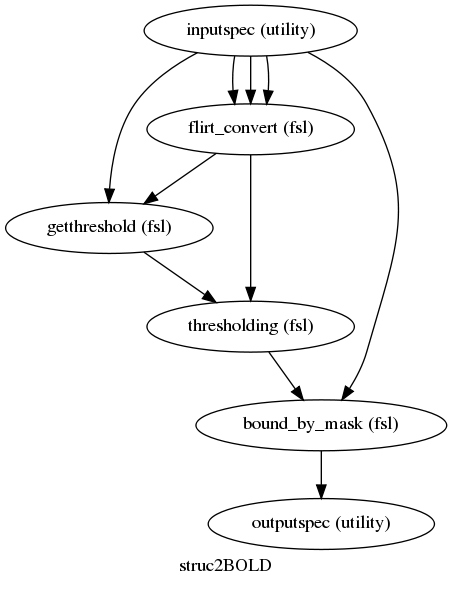

In [0]:
Image('struc2bold.jpg',height = 500)

## 10.2. Import the nipype interfaces

In [0]:
from nipype.interfaces import fsl
from nipype.pipeline import engine as pe
from nipype.interfaces import utility as util
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

### 10.2.1. codes that cannot be run on colab because we don't have the ROI masks of the FSL-Freesurfer extracted ones. 
```
# define the directory of the anatomical scans (T1.nii)
anat_dir = '/'

# search for all the FSL-Freesurfer processed masks of the ROIs
ROI_in_structural = glob(os.path.join(anat_dir,'ROIs','*fsl.nii.gz'))

# define the directory of the first session first run, from which we extract the example_func.nii.gz (the reference image)
preprocessed_functional_dir = '/func/session-1/run-01/outputs'

# define the output directory, to which we want to store the mask in BOLD space
output_dir = os.path.join(anat_dir,'ROI_BOLD')
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
        
```        
```
for roi in ROI_in_structural:
    roi = os.path.abspath(roi)
    roi_name = roi.split('/')[-1]
    simple_workflow = pe.Workflow(name = 'struc2BOLD')

    inputnode = pe.Node(interface = util.IdentityInterface(
                    fields=['flt_in_file',
                            'flt_in_matrix',
                            'flt_reference',
                            'mask']),
                    name = 'inputspec')
    outputnode = pe.Node(interface = util.IdentityInterface(
                    fields=['BODL_mask']),
                    name = 'outputspec')
    """
     flirt 
 -in /export/home/dsoto/dsoto/fmri/$s/sess2/label/$i 
 -ref /export/home/dsoto/dsoto/fmri/$s/sess2/run1_prepro1.feat/example_func.nii.gz  
 -applyxfm 
 -init /export/home/dsoto/dsoto/fmri/$s/sess2/run1_prepro1.feat/reg/highres2example_func.mat 
 -out  /export/home/dsoto/dsoto/fmri/$s/label/BOLD${i}
    """
    flirt_convert = pe.MapNode(
            interface = fsl.FLIRT(apply_xfm = True),
            iterfield = ['in_file','reference','in_matrix_file'],
            name = 'flirt_convert')
    simple_workflow.connect(inputnode,'flt_in_file',flirt_convert,'in_file')
    simple_workflow.connect(inputnode,'flt_reference',flirt_convert,'reference')
    simple_workflow.connect(inputnode,'flt_in_matrix',flirt_convert,'in_matrix_file')

    """
     fslmaths /export/home/dsoto/dsoto/fmri/$s/label/BOLD${i} -mul 2 
     -thr `fslstats /export/home/dsoto/dsoto/fmri/$s/label/BOLD${i} -p 99.6` 
    -bin /export/home/dsoto/dsoto/fmri/$s/label/BOLD${i}
    """
    def getthreshop(thresh):
        return ['-thr %.10f -Tmin -bin' % (val) for val in thresh]
    getthreshold = pe.MapNode(
            interface=fsl.ImageStats(op_string='-p 99.6'),
            iterfield = ['in_file','mask_file'],
            name='getthreshold')
    simple_workflow.connect(flirt_convert,'out_file',getthreshold,'in_file')
    simple_workflow.connect(inputnode,'mask',getthreshold,'mask_file')

    threshold = pe.MapNode(
            interface=fsl.ImageMaths(out_data_type='char',suffix='_thresh',
                                     op_string = '-Tmin -bin'),
            iterfield=['in_file','op_string'],
            name='thresholding')
    simple_workflow.connect(flirt_convert,'out_file',threshold,'in_file')
    simple_workflow.connect(getthreshold,('out_stat',getthreshop),threshold,'op_string')
#    simple_workflow.connect(threshold,'out_file',outputnode,'BOLD_mask')

    bound_by_mask = pe.MapNode(
            interface = fsl.ImageMaths(suffix='_mask',op_string='-mas'),
            iterfield=['in_file','in_file2'],
            name = 'bound_by_mask')
    simple_workflow.connect(threshold,'out_file',bound_by_mask,'in_file')
    simple_workflow.connect(inputnode,'mask',bound_by_mask,'in_file2')
    simple_workflow.connect(bound_by_mask,'out_file',outputnode,'BOLD_mask')

    # setup inputspecs 
    simple_workflow.inputs.inputspec.flt_in_file = roi
    simple_workflow.inputs.inputspec.flt_in_matrix = os.path.abspath(os.path.join(preprocessed_functional_dir,
                                                        'reg',
                                                        'highres2example_func.mat'))
    simple_workflow.inputs.inputspec.flt_reference = os.path.abspath(os.path.join(preprocessed_functional_dir,
                                                        'func',
                                                        'example_func.nii.gz'))
    simple_workflow.inputs.inputspec.mask = os.path.abspath(os.path.join(preprocessed_functional_dir,
                                                        'func',
                                                        'mask.nii.gz'))
    simple_workflow.inputs.bound_by_mask.out_file = os.path.abspath(os.path.join(output_dir,
                                                             roi_name.replace('_fsl.nii.gz',
                                                                              '_BOLD.nii.gz')))
    simple_workflow.base_dir = os.path.abspath(output_dir)
    simple_workflow.write_graph(dotfilename='{}.dot'.format(roi_name.split('.')[0]))
    simple_workflow.run()
```










## 10.3. Let's split the code from the cell above to explain it

### 10.3.1. start the for-loop:
```
for roi in ROI_in_structural:
    # make sure it is the absulote path because reasons
    roi = os.path.abspath(roi)
    # the name of each ROI is the last item of the path splitted by "/"
    roi_name = roi.split('/')[-1]
```

### 10.3.2.initialize the workflow as usual:
```
simple_workflow = pe.Workflow(name = 'struc2BOLD')

inputnode = pe.Node(interface = util.IdentityInterface(
                fields=['flt_in_file', # input file for flirt command
                        'flt_in_matrix', # input mat file for flirt command
                        'flt_reference', # reference file for flirt command
                        'mask']), # mask file for the last step of maksing the boundaries
                name = 'inputspec')
outputnode = pe.Node(interface = util.IdentityInterface(
                fields=['BODL_mask']), # output the mask in BOLD space
                name = 'outputspec')
```

### 10.3.3. flirt: inverse transformation of the masks in structural space to BOLD space
```
flirt_convert = pe.MapNode(
            interface = fsl.FLIRT(apply_xfm = True), # perform inverse transformation instead of estimate the transformation matrix
            iterfield = ['in_file','reference','in_matrix_file'],
            name = 'flirt_convert')
 # connect the input file (mask_in_structural_space.nii.gz)
simple_workflow.connect(inputnode,'flt_in_file',flirt_convert,'in_file')
# connect the input reference file (example_func.nii.gz)
simple_workflow.connect(inputnode,'flt_reference',flirt_convert,'reference')
# connect the input transformation matrix file (highres2example.mat)
simple_workflow.connect(inputnode,'flt_in_matrix',flirt_convert,'in_matrix_file')
```

### corresponding FSL command:
```
flirt 
    -in /export/home/dsoto/dsoto/fmri/$s/sess2/label/$i  # <mask.nii.gz>
    -ref /export/home/dsoto/dsoto/fmri/$s/sess2/run1_prepro1.feat/example_func.nii.gz  # <example_func.nii.gz>
    -applyxfm  # apply transformation matrix
    -init /export/home/dsoto/dsoto/fmri/$s/sess2/run1_prepro1.feat/reg/highres2example_func.mat  # <highrese2example.mat>
    -out  /export/home/dsoto/dsoto/fmri/$s/label/BOLD${i} # output file <mask_in_BOLD_space.nii.gz>
```

### 10.3.4. thresholding
```
# define a "get threshold value function", which takes the threshold value at a given percentile and transform it to a string format that can be passed to the FSL command line
def getthreshop(thresh):
    return '-mul 2 -thr %.10f -bin' % (val) for val in thresh]

# the getthreshold node that take the flirt transformed mask and binarizes the mask at 99.6 percentile, but this node does only the estimate of the cut point value but not applying the value
getthreshold = pe.MapNode(
        interface=fsl.ImageStats(op_string='-p 99.6'),
        iterfield = ['in_file','mask_file'],
        name='getthreshold')
simple_workflow.connect(flirt_convert,'out_file',getthreshold,'in_file')
simple_workflow.connect(inputnode,'mask',getthreshold,'mask_file')


# the thresholding node that take the threshold value and binarize the mask in BOLD space
threshold = pe.MapNode(
        interface=fsl.ImageMaths(out_data_type='char',suffix='_thresh',
                                 op_string = '-Tmin -bin'),
        iterfield=['in_file','op_string'],
        name='thresholding')
simple_workflow.connect(flirt_convert,'out_file',threshold,'in_file')
simple_workflow.connect(getthreshold,('out_stat',getthreshop),threshold,'op_string')
```
### corresponding FSL command:
```
fslmaths 
    /export/home/dsoto/dsoto/fmri/$s/label/BOLD${i} # <mask_in_BOLD.nii.gz>
    -mul 2                                          # multiple the image values by 2
    -thr `fslstats /export/home/dsoto/dsoto/fmri/$s/label/BOLD${i} -p 99.6`  # estimate the threshold value at 99.6 percentile and binarize the mask based on this value
    -bin /export/home/dsoto/dsoto/fmri/$s/label/BOLD${i} # <binarized_mask_in_BOLD.nii.gz>
```

### 10.3.5. bound the binarized mask by the whole brain mask (dilate mask generated in preprocessing 7.5.11)
```
bound_by_mask = pe.MapNode(
        interface = fsl.ImageMaths(suffix='_mask',op_string='-mas'),
        iterfield=['in_file','in_file2'],
        name = 'bound_by_mask')
# get the binarized ROI mask
simple_workflow.connect(threshold,'out_file',bound_by_mask,'in_file')
# get the whole brain mask
simple_workflow.connect(inputnode,'mask',bound_by_mask,'in_file2')
# multiple them. Because both masks are 1-0 matrices, so that they will zero-out the out-of-bound voxels that is wrongly transform by the highres2example transformation matrix
simple_workflow.connect(bound_by_mask,'out_file',outputnode,'BOLD_mask')
```

### corresponding FSL command:
```
fslmaths 
    <mask_in_BOLD.nii.gz> 
    -mas 
    <dilate_mask.nii.gz> 
    <output_mask.nii.gz>
```